In [1]:
import torch
import torch.nn.functional as Fun

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

DTYPE = torch.float32

In [2]:
Fun.softmax(torch.tensor([1,2,3.]), dim=0)


tensor([0.0900, 0.2447, 0.6652])

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
def in_jupyter():
	try:
		get_ipython
		return True
	except NameError:
		return False
if in_jupyter():
	from tqdm.notebook import trange
	from tqdm.notebook import tqdm
else:
	from tqdm import trange
	from tqdm import tqdm

# датасет: cпираль

In [5]:
def generate_dataset(dataset_type='spiral', n_samples=400, noise=1.3):
    """Генерация различных типов датасетов"""
    if dataset_type == 'circle':
        X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5)
    elif dataset_type == 'xor':
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
                                   n_informative=2, n_clusters_per_class=1,
                                   flip_y=0.1, class_sep=0.5)
    elif dataset_type == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=noise)
    elif dataset_type == 'spiral':
        n = n_samples // 2
        theta = np.sqrt(np.random.rand(n)) * 4 * np.pi
        r_a = 2 * theta + np.pi
        data_a = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
        x_a = data_a + np.random.normal(0,noise,(n,2))

        theta = np.sqrt(np.random.rand(n)) * 4 * np.pi
        r_b = -2 * theta - np.pi
        data_b = np.array([np.cos(theta) * r_b, np.sin(theta) * r_b]).T
        x_b = data_b + np.random.normal(0,noise,(n,2)) * noise

        X = np.vstack([x_a, x_b])
        y = np.hstack([np.zeros(n), np.ones(n)])
    else:  # linear
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
                                   n_informative=2, n_clusters_per_class=1)

    #return torch.FloatTensor(X), torch.FloatTensor(y).reshape(-1, 1)
    return X, y.reshape(-1, 1)


In [6]:
X,y = generate_dataset(noise=1.3)

In [7]:
type(X)

numpy.ndarray

In [8]:
def foo(grid):
	return np.exp(grid[:,0])+grid[:,0]

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

def as_numpy(model,X, *args, **kvargs):
	if isinstance(model,torch.nn.Module):
		with torch.no_grad():
			mp = next(model.parameters())
			return model(torch.tensor(X, dtype=mp.dtype, device=mp.device), *args, **kvargs).detach().cpu().numpy()
	else:
		return model(X)

def calc_mesh(x_min, y_min, x_max, y_max, resolution = 100):
	xx, yy = np.meshgrid(
		np.linspace(x_min, x_max, resolution),
		np.linspace(y_min, y_max, resolution)
	)

	return xx, yy, np.c_[xx.ravel(), yy.ravel()]
x_min, y_min, x_max, y_max

(np.float64(-30.31422067325809),
 np.float64(-30.033579939602184),
 np.float64(31.4470804098714),
 np.float64(30.137881188246798))

# виджеты

In [9]:
from pathlib import Path
import anywidget
import ipywidgets
from traitlets import Int as tInt, Float as tFloat, Bool as tBool, List as tList
from traitlets import Unicode as tUnicode
import numpy as np

class HeatmapWidget(anywidget.AnyWidget):
	_esm = Path("heatmap.js").read_text(encoding="utf-8")

	height = tInt().tag(sync=True)
	width = tInt().tag(sync=True)
	cell_size = tInt(10).tag(sync=True)
	colormap = tList(tList(tInt())).tag(sync=True)
	#draw_count_request = tInt(0).tag(sync=True)
	#draw_count = tInt(0).tag(sync=True)

	_data = tUnicode("").tag(sync=True)

	def __init__(self, height, width, cell_size=10, colormap=None, zmin=-1, zmid=0, zmax=1):
		super().__init__()
		self.height = height
		self.width = width
		self.cell_size = cell_size
		self.colormap = [[40,136,196],[227,232,234],[245,150,40]] if colormap is None else colormap
		assert zmin<zmid<zmax , f'should be zmin<zmid<zmax: {zmin}<{zmid}<{zmax}'
		self.zmin = zmin
		self.zmid = zmid
		self.zmax = zmax
		#self.draw_call_count = 0
		#self.saved_data = ''
		#self.same_data_count = 0

	def draw(self,arr):
		v = arr.reshape(-1) - self.zmid
		assert len(v) == self.height * self.width, len(v)
		a = 128 / (self.zmid - self.zmin)
		b = 128 / (self.zmax - self.zmid)
		out =  np.clip(np.where(v<=0, v*a, v*b) + 128, 0, 255)
		data = (out + 100).astype('uint32').tobytes().decode('utf-32-le')
		#if data==self.saved_data:
		#	self.same_data_count+=1
		#self.saved_data = data
		self._data = data
		#self.draw_call_count += 1
		#return data


In [10]:
h, w = 50, 150
wgt = HeatmapWidget(height=h, width=w, cell_size=4)
wgt.draw(np.random.rand(h, w)*2-1)
wgt

In [11]:
#%timeit wgt.draw(np.random.rand(h, w)*2-1)

import time
for i in range(200):
	wgt.draw(np.random.rand(h, w)*2-1)
	time.sleep(0.03)

In [12]:
X.shape, y.shape

((400, 2), (400, 1))

In [13]:
class HeatmapWithPoints(HeatmapWidget):
	_esm = Path("heatmap_with_points.js").read_text(encoding="utf-8")

	# просто держим пустую модель (на будущее можно добавить атрибуты)
	points = tList(tList(tFloat())).tag(sync=True)
	bb = tList(tFloat(), default_value=[0, 0, 1, 1]).tag(sync=True)
	def __init__(self, *args, points=None, bb=None, **kwargs):
		super().__init__(*args, **kwargs)
		self.points = [] if points is None else points
		self.bb = bb if bb is not None else [0, 0, 1, 1]
	def _clipz(self,c):
		if c<self.zmid:
			if c<self.zmin: return 0
			else: return int(128-(c-self.zmid)/(self.zmin-self.zmid)*128)
		else:
			if c>self.zmax: return 255
			else: return int(128+(c-self.zmid)/(self.zmax-self.zmid)*128)
	def draw_points(self,X,z):# slow function
		self.points = [(float(a),float(b),self._clipz(c)) for ((a,b),(c,)) in zip(X,y)]

In [14]:
w = HeatmapWithPoints(width=5, height=5, cell_size=100, bb=[0, 0, 100, 200])
w

In [15]:
w.points = [
	[1,   0,   255],	# левый нижний угол
	[100, 200, 0],		# правый верхний угол
	[50,  100, 128],	# центр
]

In [16]:
w.draw(np.random.randn(5, 5))

In [17]:
w.cell_size = 40

In [18]:
w = HeatmapWithPoints(height=50, width=50, cell_size=8, bb=[0,0,50,50])

# фон
w.draw(np.random.randn(50,50))

# точки
w.points = [
	[10, 10, 255],
	[20, 15, 128],
	[40, 35,   0],
]

w

In [19]:
w.draw(np.random.randn(50,50))

In [20]:
def foo(grid):
	return np.exp(grid[:,0])+grid[:,0]*0.1+0.5

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

def as_numpy(model,X, *args, **kvargs):
	if isinstance(model,torch.nn.Module):
		with torch.no_grad():
			mp = next(model.parameters())
			return model(torch.tensor(X, dtype=mp.dtype, device=mp.device), *args, **kvargs).detach().cpu().numpy()
	else:
		return model(X)

def calc_mesh(x_min, y_min, x_max, y_max, resolution = 100):
	xx, yy = np.meshgrid(
		np.linspace(x_min, x_max, resolution),
		np.linspace(y_min, y_max, resolution)
	)

	return xx, yy, np.c_[xx.ravel(), yy.ravel()]

def draw_mesh(foo, wgt, x_min, y_min, x_max, y_max, resolution = 100, cmin=-10, cmax=10):
	xx,yy,grid = calc_mesh(x_min, y_min, x_max, y_max, resolution = 100)
	Z = as_numpy(foo,grid)
	wgt.draw(Z.reshape(xx.shape))

w = HeatmapWithPoints(height=100, width=100, cell_size=4, bb=[x_min,y_min,x_max,y_max],zmin=0,zmid=0.5,zmax=1)
draw_mesh(foo,w,x_min, y_min, x_max, y_max)
w.draw_points(X,y)
w

In [21]:
class HistoryPlot(anywidget.AnyWidget):
	_esm = Path("history_plot.js").read_text(encoding="utf-8")

	_new_x = tInt(-1).tag(sync=True)
	_new_y = tFloat(0.0).tag(sync=True)

	maxlen = tInt().tag(sync=True)
	width = tInt().tag(sync=True)
	height = tInt().tag(sync=True)
	logmode = tBool().tag(sync=True)

	def __init__(self, maxlen=1500, width = 500, height = 100):
		super().__init__()
		self._counter = 0
		self.maxlen = maxlen
		self.width = width
		self.height = height

	def update(self, value: float):
		self._new_y = float(value)
		self._new_x = self._counter # триггер обновления, должен быть после обновления _new_y
		self._counter += 1

	def skip(self):
		self._counter += 1


In [22]:
plot = HistoryPlot()
plot

In [23]:

for y1 in np.random.rand(1000)*2-1:
	plot.update(y1)
	time.sleep(0.03)

In [24]:
plot = HistoryPlot(maxlen=5)
plot

In [25]:
plot.update(3.141111111)

In [26]:
plot.update(2.0)

In [27]:
plot.update(100)

In [28]:
plot.logmode = True

In [29]:
plot

In [30]:
plot.update(1)

In [31]:
plot.skip()

In [32]:
plot.update(3)

In [33]:
plot.update(2)

In [34]:
plot.update(5)

In [35]:
plot.update(4)

In [36]:
plot.update(4)

In [37]:
plot.update(4)

In [38]:
plot.update(4)

In [39]:
plot.update(4)

# модель на виджетах

In [40]:
import torch.nn as nn
import ipywidgets

In [41]:
class FeedForward(torch.nn.Module):
	"""Простая нейронная сеть с настраиваемой архитектурой"""
	def __init__(self, input_size=2, hidden_layers=[4, 4], activation=None, dtype=DTYPE):
		if activation is None: activation = lambda x: x
		super(FeedForward, self).__init__()

		self.layers = nn.ModuleList()
		self.activations = []
		self.activation_type = activation

		prev_size = input_size

		# Скрытые слои
		for hidden_size in hidden_layers:
			self.layers.append(nn.Linear(prev_size, hidden_size, dtype=dtype))
			self.activations.append(activation)
			prev_size = hidden_size

		# Выходной слой
		self.layers.append(nn.Linear(prev_size, 1))
		self.activations.append(nn.Sigmoid())

		# Для хранения промежуточных значений во время отрисовки состояния
		self.layer_outputs = []
		self.can_draw = 0
		# 0 - no data
		# 1 - has data, no axes
		# 2 - has data, has_axes
		self.drawing = False

	def forward(self, X):
		if self.drawing:
			self.layer_outputs = []
		for i, (layer, activation) in enumerate(zip(self.layers, self.activations)):
			X = activation(layer(X))
			if self.drawing:
				self.layer_outputs.append(X.detach().clone())

		return X

	# __DRAW_INTERFACE__
	def init_draw(self,X):
		self.layer_outputs = []
		self.resolution = 30
		self.x_min, self.x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
		self.y_min, self.y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
		self.xx, self.yy, self.grid = calc_mesh(
			self.x_min, self.y_min, self.x_max, self.y_max, resolution = self.resolution)
		mp = next(self.parameters())
		self.grid = torch.tensor(self.grid, dtype=mp.dtype, device=mp.device)
		self.can_draw = 1

	def calc_draw(self):
		self.drawing = True
		with torch.no_grad():
			tmp = self.forward(self.grid)
		self.drawing = False
		return tmp

	def draw_layers(self):
		assert self.can_draw >=1
		self.can_draw = 2
		self.widgets = []
		for ln in range(len(self.layers)-1):
			l_widgets = []
			for nn in range(self.layers[ln].out_features):
				widget = HeatmapWidget(self.resolution, self.resolution, cell_size=2, zmin=-2, zmid=0, zmax=2)
				widget.draw(self.layer_outputs[ln][:,nn].cpu())
				l_widgets.append(widget)
			self.widgets.append(ipywidgets.VBox(l_widgets))
		self.widgets = ipywidgets.HBox(self.widgets)
		return self.widgets

	def redraw_layers(self):
		assert self.can_draw >=2, self.can_draw
		for ln in range(len(self.layers)-1):
			for nn in range(self.layers[ln].out_features):
				Z = self.layer_outputs[ln][:,nn].cpu()
				self.widgets.children[ln].children[nn].draw(Z.reshape(self.xx.shape))

	def draw(self):
		self.out_resolution = 80
		self.out_xx, self.out_yy, self.out_grid = calc_mesh(
			self.x_min, self.y_min, self.x_max, self.y_max, resolution = self.out_resolution)
		mp = next(self.parameters())
		self.out_grid = torch.tensor(self.out_grid, dtype=mp.dtype, device=mp.device)
		with torch.no_grad():
			Z = self.forward(self.out_grid).cpu()
		self.out_wgt = HeatmapWithPoints(
			height=self.out_resolution, width=self.out_resolution, cell_size=4, bb=[x_min,y_min,x_max,y_max],zmin=0,zmid=0.5,zmax=1)
		self.out_wgt.draw(Z.reshape(self.out_xx.shape))
		return self.out_wgt

	def redraw(self):
		with torch.no_grad():
			Z = self.forward(self.out_grid).cpu()
		self.out_wgt.draw(Z.reshape(self.out_xx.shape))
		return self.out_wgt


# учим онлайн на виджетах

In [42]:
type(X), X.shape, type(y), y.shape

(numpy.ndarray, (400, 2), numpy.ndarray, (400, 1))

In [48]:
import threading
import sys
import time

# === model ===
model = FeedForward(2, [5, 5, 5, 5, 5], nn.ReLU())
# веса инициализируются по дефолту
criterion = nn.BCELoss()


In [53]:
# === обновление параметров ===
printput = ipywidgets.Output()

learning_rate = 0.001
lr_changed = True
def update_learning_rate():
	global optimizer
	optimizer = optim.Adam(model.parameters(), lr=learning_rate)
	#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
	global lr_changed
	lr_changed = False

#device='cuda'
device='cpu'
train_set = TensorDataset(torch.tensor(X, dtype=DTYPE).to(device), torch.tensor(y, dtype=DTYPE).to(device))
model.to(device)
batch_size = 16
bs_changed = True
def update_batch_size():
	global loader
	loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
	# suffle происходит при каждом вызове iter()/for
	global bs_changed
	bs_changed = False

loss_history = []
lr_history = []
bs_history = []

# === отрисовка ===
if 1:
	model.init_draw(X)
	model.calc_draw()
	layers_output = model.draw_layers()
	main_heatmap = model.draw()
	main_heatmap.draw_points(X,y)

	info = ipywidgets.Label(value='ня ня ня')
	loss_wgt = HistoryPlot()
	lr_wgt = HistoryPlot()
	bs_wgt = HistoryPlot()

	def redraw():
		t0 = time.time()
		model.calc_draw()
		t1 = time.time()
		model.redraw_layers()
		model.redraw()
		info.value = f"epoch={len(loss_history)} ; loss={loss_history[-1] if len(loss_history)>0 else '':.4}"

		t2 = time.time()

		return (t1-t0, t2-t1)

	update_learning_rate()
	update_batch_size()
	redraw()

# === обучение ===
running = False
def learn():
	global loss_history
	prof_t0 = time.time()
	prof_calc_draw = 0
	prof_draw = 0
	prof_forward = 0
	prof_backward = 0
	prof_step = 0

	t0 = time.time()
	print('start')
	while running:
		if lr_changed: update_learning_rate()
		if bs_changed: update_batch_size()
		mean_loss = 0
		n_batch = 0
		for X,y in loader:
			prof_t2 = time.time()
			loss = criterion(model(X), y)
			prof_t3 = time.time()
			optimizer.zero_grad()
			prof_t4 = time.time()
			loss.backward()
			prof_t5 = time.time()
			optimizer.step()
			prof_t6 = time.time()

			prof_forward+= (prof_t3 - prof_t2)
			prof_backward+= (prof_t5 - prof_t4)
			prof_step+= (prof_t6 - prof_t5)
			mean_loss += loss.item()
			n_batch +=1

		loss_history.append(mean_loss/n_batch)
		lr_history.append(optimizer.param_groups[0]['lr'])
		bs_history.append(loader.batch_size)

		if time.time() - t0 > 0.03:
			t0 = time.time()
			a,b = redraw()
			prof_calc_draw +=a
			prof_draw +=b
			print(len(loss_history),time.time() - prof_t0, '--',prof_forward,prof_backward,prof_step,prof_calc_draw, prof_draw)
			loss_wgt.update(loss_history[-1])
			lr_wgt.update(lr_history[-1])
			bs_wgt.update(bs_history[-1])
		else:
			pass
			loss_wgt.skip()
			lr_wgt.skip()
			bs_wgt.skip()
	redraw()

# === управление ===
start_stop = ipywidgets.ToggleButton(value=False, description='Старт', icon='play')
@printput.capture(clear_output=False)
def on_toggle(change):
	global running
	if change['new']:
		start_stop.description = 'Стоп'
		start_stop.icon = 'pause'
		running = True
		threading.Thread(target=learn, daemon=True).start()
	else:
		start_stop.description = 'Старт'
		start_stop.icon = 'play'
		running = False
start_stop.observe(on_toggle, names='value')

def f(k): return [10*k,22*k,47*k]
lr_slider = ipywidgets.SelectionSlider(
	options=f(1e-6)+f(1e-5)+f(1e-4)+f(1e-3)+f(1e-2)+f(1e-1)+f(1e0),
	value=learning_rate,
	description='Learning Rate',
	continuous_update=True
)
@printput.capture(clear_output=False)
def lr_change(change):
	global learning_rate, lr_changed
	learning_rate = change['new']
	lr_changed = True
lr_slider.observe(lr_change, names='value')

bs_slider = ipywidgets.SelectionSlider(
	options=[1,2,4,8,16,32,64,128,256],
	value=batch_size,
	description='Batch size',
	continuous_update=True
)
@printput.capture(clear_output=False)
def bs_change(change):
	global batch_size, bs_changed
	batch_size = change['new']
	bs_changed = True
bs_slider.observe(bs_change, names='value')

display(
	ipywidgets.HBox([start_stop,lr_slider,bs_slider]),
	printput,
	info,
	loss_wgt,
	lr_wgt,
	bs_wgt,
	ipywidgets.HBox([layers_output,main_heatmap]))

Output()

Label(value='epoch=0 ; loss=')

# графики на matplotlib

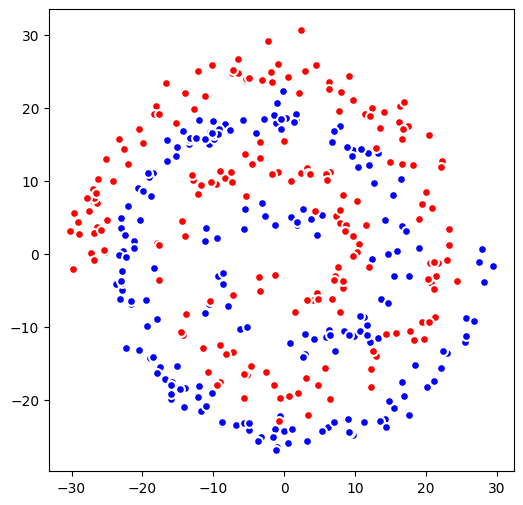

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 6))

def draw_dots(X,y,ax):
	#X_np, y_np = X.numpy(), y.numpy().flatten()
	X_np, y_np = X, y.flatten()
	ax.scatter(X_np[y_np == 0, 0], X_np[y_np == 0, 1], 
			   c='blue', s=40, edgecolors='white', linewidths=1.5, label='Class 0')
	ax.scatter(X_np[y_np == 1, 0], X_np[y_np == 1, 1], 
			   c='red', s=40, edgecolors='white', linewidths=1.5, label='Class 1')

draw_dots(X,y,ax)
#ax.set_xlim(x_min, x_max)
#ax.set_ylim(y_min, y_max)
plt.show()

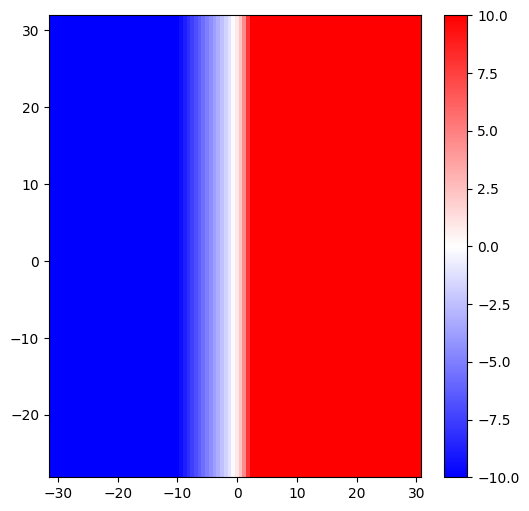

In [14]:
def foo(grid):
	return np.exp(grid[:,0])+grid[:,0]

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

def as_numpy(model,X, *args, **kvargs):
	if isinstance(model,torch.nn.Module):
		with torch.no_grad():
			mp = next(model.parameters())
			return model(torch.tensor(X, dtype=mp.dtype, device=mp.device), *args, **kvargs).detach().cpu().numpy()
	else:
		return model(X)
		
def calc_mesh(x_min, y_min, x_max, y_max, resolution = 100):
	xx, yy = np.meshgrid(
		np.linspace(x_min, x_max, resolution),
		np.linspace(y_min, y_max, resolution)
	)

	return xx, yy, np.c_[xx.ravel(), yy.ravel()]

def draw_mesh(foo, ax, x_min, y_min, x_max, y_max, resolution = 100, cmin=-10, cmax=10):
	xx,yy,grid = calc_mesh(x_min, y_min, x_max, y_max, resolution = 100)
	Z = as_numpy(foo,grid)
	norm = mcolors.TwoSlopeNorm(vmin=cmin, vcenter=0, vmax=cmax)
	
	return ax.pcolormesh(xx, yy, Z.reshape(xx.shape), cmap='bwr', norm=norm)

fig, ax = plt.subplots(figsize=(6, 6))
tmp = draw_mesh(foo,ax,x_min, y_min, x_max, y_max)
plt.colorbar(tmp, ax=ax)

plt.show()

# модели на matplotlib

In [15]:
import torch.nn as nn

In [16]:
class FeedForward(torch.nn.Module):
	"""Простая нейронная сеть с настраиваемой архитектурой"""
	def __init__(self, input_size=2, hidden_layers=[4, 4], activation=None, dtype=DTYPE):
		if activation is None: activation = lambda x: x
		super(FeedForward, self).__init__()

		self.layers = nn.ModuleList()
		self.activations = []
		self.activation_type = activation

		prev_size = input_size

		# Скрытые слои
		for hidden_size in hidden_layers:
			self.layers.append(nn.Linear(prev_size, hidden_size, dtype=dtype))
			self.activations.append(activation)
			prev_size = hidden_size

		# Выходной слой
		self.layers.append(nn.Linear(prev_size, 1))
		self.activations.append(nn.Sigmoid())

		# Для хранения промежуточных значений во время отрисовки состояния
		self.layer_outputs = []
		self.can_draw = 0
		# 0 - no data
		# 1 - has data, no axes
		# 2 - has data, has_axes
		self.drawing = False

	def forward(self, X):
		for i, (layer, activation) in enumerate(zip(self.layers, self.activations)):
			X = activation(layer(X))
			if self.drawing:
				self.layer_outputs.append(X.detach().clone())

		return X

	# __DRAW_INTERFACE__
	def init_draw(self,X):
		self.layer_outputs = []
		self.x_min, self.x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
		self.y_min, self.y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
		self.xx, self.yy, self.grid = calc_mesh(
			self.x_min, self.y_min, self.x_max, self.y_max, resolution = 50)
		mp = next(self.parameters())
		self.grid = torch.tensor(self.grid, dtype=mp.dtype, device=mp.device)
		self.can_draw = 1

	def calc_draw(self):
		self.drawing = True
		tmp = self.forward(self.grid)
		self.drawing = False
		return tmp

	def draw_grid_size(self):
		return max(x.out_features for x in self.layers), len(self.layers)-1

	def draw_layers(self, fig, gs):
		assert self.can_draw >=1
		self.can_draw = 2
		self.axes = []
		self.plots = []
		for ln in range(len(self.layers)-1):
			l_axes = []
			l_plots = []
			for nn in range(self.layers[ln].out_features):
				ax = fig.add_subplot(gs[nn,ln])
				l_axes.append(ax)
				Z = self.layer_outputs[ln][:,nn].cpu()
				norm = mcolors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)
				plot = ax.pcolormesh(self.xx, self.yy, Z.reshape(self.xx.shape), cmap='bwr', norm=norm)
				l_plots.append(plot)
			self.axes.append(l_axes)
			self.plots.append(l_plots)

	def redraw_layers(self):
		assert self.can_draw >=2, self.can_draw
		for ln in range(len(self.layers)-1):
			for nn in range(self.layers[ln].out_features):
				Z = self.layer_outputs[ln][:,nn].cpu()
				self.plots[ln][nn].set_array(Z.reshape(self.xx.shape))

	def draw(self, ax):
		Z = self.layer_outputs[-1][:,0].cpu()
		norm = mcolors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)
		return ax.pcolormesh(self.xx, self.yy, Z.reshape(self.xx.shape), cmap='bwr', norm=norm)

	def redraw(self,plot):
		Z = self.layer_outputs[-1][:,0].cpu()
		plot.set_array(Z.reshape(self.xx.shape))

In [17]:
lin = nn.Linear(2, 3)
for x in lin.parameters():
	print(type(x),x)

<class 'torch.nn.parameter.Parameter'> Parameter containing:
tensor([[ 0.0359,  0.5808],
        [-0.3254,  0.5086],
        [ 0.4152, -0.4937]], requires_grad=True)
<class 'torch.nn.parameter.Parameter'> Parameter containing:
tensor([ 0.3385, -0.0083, -0.0658], requires_grad=True)


In [18]:
def init_weights(m):
	print(type(m),m)

model = FeedForward(2, [20, 20, 20], nn.ReLU())
model.apply(init_weights)

<class 'torch.nn.modules.linear.Linear'> Linear(in_features=2, out_features=20, bias=True)
<class 'torch.nn.modules.linear.Linear'> Linear(in_features=20, out_features=20, bias=True)
<class 'torch.nn.modules.linear.Linear'> Linear(in_features=20, out_features=20, bias=True)
<class 'torch.nn.modules.linear.Linear'> Linear(in_features=20, out_features=1, bias=True)
<class 'torch.nn.modules.container.ModuleList'> ModuleList(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
  (3): Linear(in_features=20, out_features=1, bias=True)
)
<class 'torch.nn.modules.activation.ReLU'> ReLU()
<class '__main__.FeedForward'> FeedForward(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (activation_type): ReLU()
)


FeedForward(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (activation_type): ReLU()
)

In [19]:
model.draw_grid_size()

(20, 3)

In [20]:
type(as_numpy(model,X))

numpy.ndarray

In [21]:
model.layers[0].weight.dtype

torch.float32

# учим онлайн на matplotlib

In [22]:
type(X)

numpy.ndarray

8 6


Output()

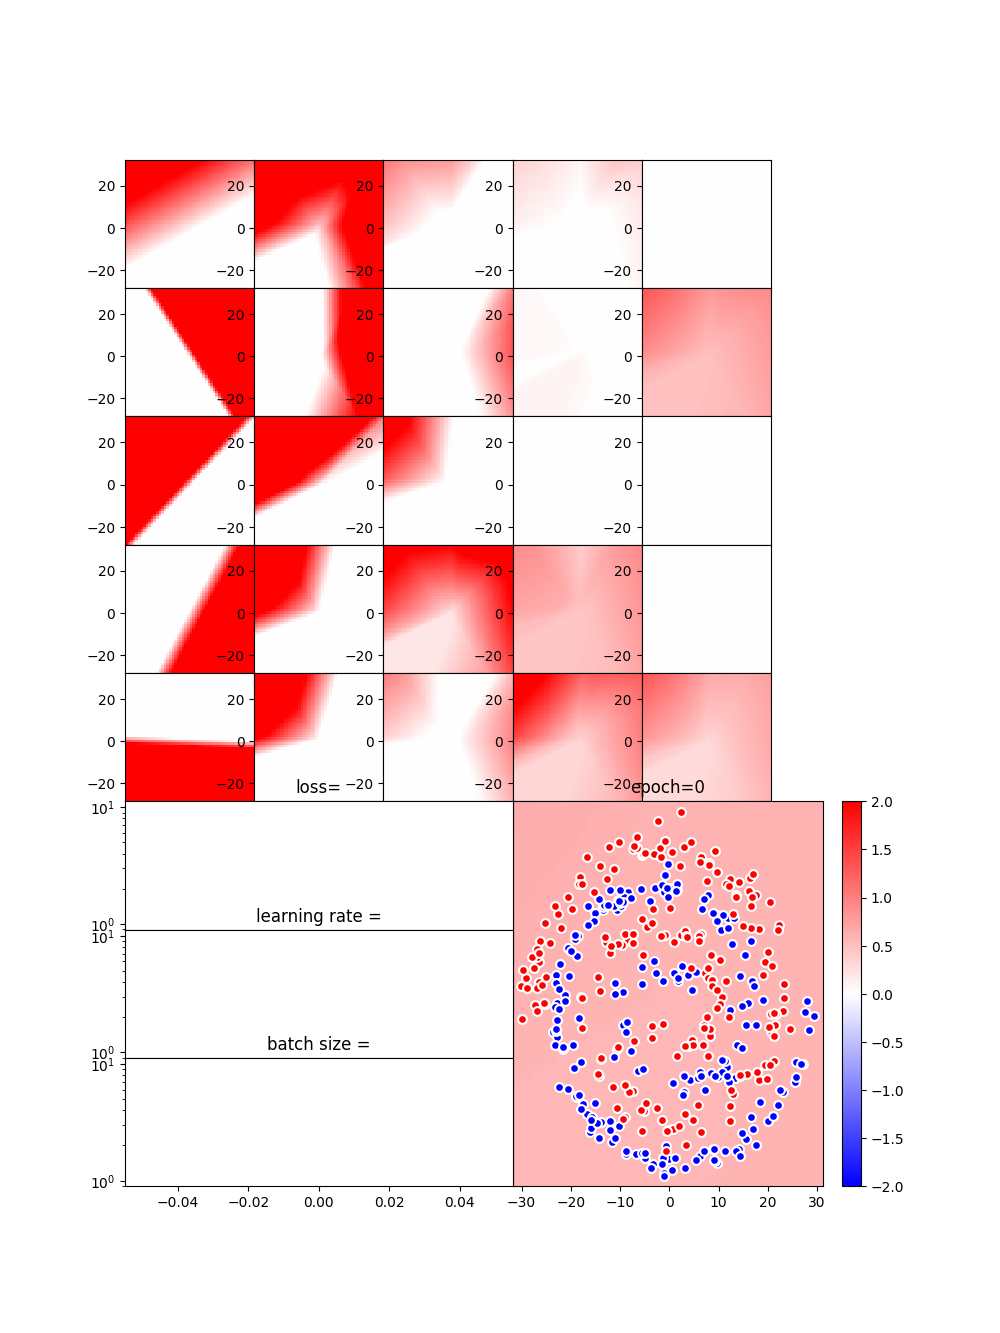

In [23]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import ipywidgets as widgets
import threading
import sys
import time

# === model ===
model = FeedForward(2, [5, 5, 5, 5, 5], nn.ReLU())
# веса инициализируются по дефолту
criterion = nn.BCELoss()

# === обновление параметров ===
printput = widgets.Output()

learning_rate = 0.001
lr_changed = True
def update_learning_rate():
	global optimizer
	optimizer = optim.Adam(model.parameters(), lr=learning_rate)
	#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
	global lr_changed
	lr_changed = False

#device='cuda'
device='cpu'
train_set = TensorDataset(torch.tensor(X, dtype=DTYPE).to(device), torch.tensor(y, dtype=DTYPE).to(device))
model.to(device)
batch_size = 16
bs_changed = True
def update_batch_size():
	global loader
	loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
	# suffle происходит при каждом вызове iter()/for
	global bs_changed
	bs_changed = False

loss_history = []
lr_history = []
bs_history = []

# === отрисовка ===
if 1:
	plot_h, plot_w = model.draw_grid_size()
	plot_w = max(plot_w,6)
	plot_h +=3
	print(plot_h,plot_w)
	fig = plt.figure(figsize=(10,10/plot_w*plot_h))
	gs = GridSpec(plot_h,plot_w,figure=fig, hspace=0, wspace=0)
	#fig, ax_main = plt.subplots(figsize=(8, 8))
	
	model.init_draw(X)
	model.calc_draw()
	
	model.draw_layers(fig,gs)
	
	ax_main = fig.add_subplot(gs[-3:,-3:])
	pl_main = model.draw(ax_main)
	plt.colorbar(pl_main, ax=ax_main)
	ttl_main = ax_main.set_title('0')
	draw_dots(X,y,ax_main)
	
	ax_loss = fig.add_subplot(gs[-3,:-3])
	pl_loss, = ax_loss.plot(loss_history)
	ax_loss.set_yscale("log")
	ttl_loss = ax_loss.set_title('loss')
	
	ax_lr = fig.add_subplot(gs[-2,:-3])
	pl_lr, = ax_lr.plot(lr_history)
	ax_lr.set_yscale("log")
	ttl_lr = ax_lr.set_title('learning rate')
	
	ax_bs = fig.add_subplot(gs[-1,:-3])
	pl_bs, = ax_bs.plot(bs_history)
	ax_bs.set_yscale("log")
	ttl_bs = ax_bs.set_title('batch size')
	
	xx,yy,grid = calc_mesh(x_min, y_min, x_max, y_max, resolution = 100)
	def redraw():
		t0 = time.time()
		model.calc_draw()
	
		model.redraw_layers()
	
		model.redraw(pl_main)
		ttl_main.set_text(f"epoch={len(loss_history)}")
	
		pl_loss.set_data(list(range(len(loss_history))), loss_history)
		ax_loss.relim()
		ax_loss.autoscale_view()
		ttl_loss.set_text(f"loss={loss_history[-1] if len(loss_history)>0 else '':.4}")
	
		pl_lr.set_data(list(range(len(lr_history))), lr_history)
		ax_lr.relim()
		ax_lr.autoscale_view()
		ttl_lr.set_text(f"learning rate ={lr_history[-1] if len(lr_history)>0 else '':.4}")
	
		pl_bs.set_data(list(range(len(bs_history))), bs_history)
		ax_bs.relim()
		ax_bs.autoscale_view()
		ttl_bs.set_text(f"batch size ={bs_history[-1] if len(bs_history)>0 else ''}")
	
		t1 = time.time()
		fig.canvas.draw_idle()
		t2 = time.time()
		return (t1-t0, t2-t1)
	
	update_learning_rate()
	update_batch_size()
	redraw()

# === обучение ===
running = False
def learn():
	global loss_history
	prof_t0 = time.time()
	prof_calc_draw = 0
	prof_draw = 0
	prof_forward = 0
	prof_backward = 0
	prof_step = 0

	t0 = time.time()
	print('start')
	while running:
		if lr_changed: update_learning_rate()
		if bs_changed: update_batch_size()
		mean_loss = 0
		n_batch = 0
		for X,y in loader:
			prof_t2 = time.time()
			loss = criterion(model(X), y)
			prof_t3 = time.time()
			optimizer.zero_grad()
			prof_t4 = time.time()
			loss.backward()
			prof_t5 = time.time()
			optimizer.step()
			prof_t6 = time.time()

			prof_forward+= (prof_t3 - prof_t2)
			prof_backward+= (prof_t5 - prof_t4)
			prof_step+= (prof_t6 - prof_t5)
			mean_loss += loss.item()
			n_batch +=1

		loss_history.append(mean_loss/n_batch)
		lr_history.append(optimizer.param_groups[0]['lr'])
		bs_history.append(loader.batch_size)

		if time.time() - t0 > 0.03:
			t0 = time.time()
			a,b = 0,0 #redraw()
			prof_calc_draw +=a
			prof_draw +=b
			print(len(loss_history),time.time() - prof_t0, '--',prof_forward,prof_backward,prof_step,prof_calc_draw, prof_draw)
	redraw()

# === управление ===
start_stop = widgets.ToggleButton(value=False, description='Старт', icon='play')
@printput.capture(clear_output=False)
def on_toggle(change):
	global running
	if change['new']:
		start_stop.description = 'Стоп'
		start_stop.icon = 'pause'
		running = True
		threading.Thread(target=learn, daemon=True).start()
	else:
		start_stop.description = 'Старт'
		start_stop.icon = 'play'
		running = False
start_stop.observe(on_toggle, names='value')

def f(k): return [10*k,22*k,47*k]
lr_slider = widgets.SelectionSlider(
	options=f(1e-6)+f(1e-5)+f(1e-4)+f(1e-3)+f(1e-2)+f(1e-1)+f(1e0)+f(1e1),
	value=learning_rate,
	description='Learning Rate',
	continuous_update=True
)
@printput.capture(clear_output=False)
def lr_change(change):
	global learning_rate, lr_changed
	learning_rate = change['new']
	lr_changed = True
lr_slider.observe(lr_change, names='value')

bs_slider = widgets.SelectionSlider(
	options=[1,2,4,8,16,32,64,128,256],
	value=batch_size,
	description='Batch size',
	continuous_update=True
)
@printput.capture(clear_output=False)
def bs_change(change):
	global batch_size, bs_changed
	batch_size = change['new']
	bs_changed = True
bs_slider.observe(bs_change, names='value')

display(widgets.HBox([start_stop,lr_slider,bs_slider]),printput)
plt.show()


реализовать NNplayground на torch  
	`foo(число_эпох)` и в конце картинки для каждого нейрона  
	`foo(inf)` обновлять картинки 1р/сек, по прерыванию останавливаться после эпохи  

In [11]:
"""
Neural Network Playground - PyTorch Implementation
Интерактивная визуализация обучения нейронной сети
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import ipywidgets as widgets
from sklearn.datasets import make_classification, make_circles, make_moons

# Установка случайного seed для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

# графики на plotly

In [9]:
mycolormap_pl = [[0.0, 'rgb(40,136,196)'],
 [0.5, 'rgb(227,232,234)'],
 [1.0, 'rgb(245,150,40)']]
mycolormap_ipw = [[40,136,196],[227,232,234],[245,150,40]]

In [10]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
fig = go.Figure()

def draw_dots(X,y):
	#X_np, y_np = X.numpy(), y.numpy().flatten()
	X_np, y_np = X, y.flatten()
	m = go.Scatter(x = X_np[y_np == 0, 0], y = X_np[y_np == 0, 1],
			   mode='markers', marker=dict(color=mycolormap_pl[0][1], size=6, line=dict(width=1, color='white')), name='Class 0')
	p = go.Scatter(x = X_np[y_np == 1, 0], y = X_np[y_np == 1, 1], 
			   mode='markers', marker=dict(color=mycolormap_pl[2][1], size=6, line=dict(width=1, color='white')), name='Class 1')
	return m,p
xx,yy,grid = calc_mesh(x_min, y_min, x_max, y_max, resolution = 100)
Z = as_numpy(foo,grid)

fig.add_trace(go.Heatmap(
	z=Z.reshape(xx.shape),
	zmin=-10, zmid=0, zmax=10,
	colorscale = mycolormap_pl,
		#get_colorscale('RdBu')[::-1],
		#[	[0.0, 'blue'],	[0.5, 'white'],	[1.0, 'red'],],
	x=xx[0],
	y=yy[:,0],
	showscale=True))

m,p = draw_dots(X,y)
fig.add_trace(p)
fig.add_trace(m)

fig.update_layout(margin=dict(l=3,r=3,t=3,b=3), width=600, height=600)
fig.show()

In [11]:
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display

x = np.linspace(0, 2*np.pi, 500)
freq = 1.0

fig = go.FigureWidget(make_subplots(rows=2, cols=2))

# добавляем графики
fig.add_trace(go.Scatter(x=x, y=np.sin(freq*x), mode='lines'), row=1, col=1)
fig.add_trace(go.Scatter(x=x, y=np.cos(freq*x), mode='lines'), row=1, col=2)
fig.add_trace(go.Scatter(x=x, y=np.exp(-freq*x), mode='lines'), row=2, col=1)
fig.add_trace(go.Scatter(x=x, y=np.sin(2*freq*x), mode='lines'), row=2, col=2)

# сохраняем ссылки на trace
trace_refs = [fig.data[i] for i in range(4)]

# отключаем drag/hover уже через layout FigureWidget
fig.layout.update(
	width=800,
	height=600,
	margin=dict(l=20, r=20, t=20, b=20),
	dragmode=False,
	hovermode=False
)

slider = widgets.FloatSlider(value=freq, min=0.1, max=10, step=0.1, description="freq")

def on_change(change):
	with fig.batch_update():
		f = change['new']
		trace_refs[0].y = np.sin(f*x)
		trace_refs[1].y = np.cos(f*x)
		trace_refs[2].y = np.exp(-f*x)
		trace_refs[3].y = np.sin(2*f*x)

slider.observe(on_change, names='value')
display(fig, slider)


FigureWidget({
    'data': [{'mode': 'lines',
              'type': 'scatter',
              'uid': 'd159c37c-e2fa-4db8-8693-f91cb5c0bd8f',
              'x': {'bdata': ('AAAAAAAAAABJG4e7mcmJP0kbh7uZyZ' ... 'oxCBlAimlmhxYVGUAYLURU+yEZQA=='),
                    'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': ('AAAAAAAAAABsmj0TbcmJP7d/dxvnyJ' ... 'vnyJm/sZs9E23Jib8HXBQzJqaxvA=='),
                    'dtype': 'f8'},
              'yaxis': 'y'},
             {'mode': 'lines',
              'type': 'scatter',
              'uid': '6d1c370c-b5f3-46ea-8123-3cff8b1a5e0c',
              'x': {'bdata': ('AAAAAAAAAABJG4e7mcmJP0kbh7uZyZ' ... 'oxCBlAimlmhxYVGUAYLURU+yEZQA=='),
                    'dtype': 'f8'},
              'xaxis': 'x2',
              'y': {'bdata': ('AAAAAAAA8D8Rmt3AWf/vP0jHNQpn/e' ... 'pn/e8/EZrdwFn/7z8AAAAAAADwPw=='),
                    'dtype': 'f8'},
              'yaxis': 'y2'},
             {'mode': 'lines',
              'type': 'scatter',
   

FloatSlider(value=1.0, description='freq', max=10.0, min=0.1)

In [12]:
import numpy as np
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import display

x = np.linspace(0, 2*np.pi, 500)
freq = 1.0

# FigureWidget без реакции на мышь
fig = go.FigureWidget(
    data=[
        go.Scatter(x=x, y=np.sin(freq*x), mode='lines', name='sin(freq*x)'),
        go.Scatter(x=x, y=np.cos(freq*x), mode='lines', name='cos(freq*x)'),
        go.Scatter(x=x, y=np.exp(-freq*x), mode='lines', name='exp(-freq*x)')
    ],
    layout=dict(
        width=700, height=500,
        margin=dict(l=40, r=20, t=20, b=40),
        dragmode=False,
        hovermode=False
    )
)

# --- горизонтальное разделение для sin и cos ---
fig.update_layout(
    xaxis=dict(domain=[0, 0.48], title='x'),
    xaxis2=dict(domain=[0.52, 1], title='x'),
    xaxis3=dict(domain=[0, 1], title='x'),  # для экспоненты под ними
    yaxis=dict(domain=[0.35, 1], title='sin(freq*x)'),
    yaxis2=dict(domain=[0.35, 1], title='cos(freq*x)'),
    yaxis3=dict(domain=[0, 0.32], title='exp(-freq*x)')
)

# Привязка каждой линии к своей оси
fig.data[0].update(xaxis='x', yaxis='y')
fig.data[1].update(xaxis='x2', yaxis='y2')
fig.data[2].update(xaxis='x3', yaxis='y3')

# --- Ползунок частоты ---
slider = widgets.FloatSlider(value=freq, min=0.1, max=10, step=0.1, description="freq")

def on_change(change):
    f = change['new']
    with fig.batch_update():
        fig.data[0].y = np.sin(f*x)
        fig.data[1].y = np.cos(f*x)
        fig.data[2].y = np.exp(-f*x)

slider.observe(on_change, names='value')

display(fig, slider)


FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'sin(freq*x)',
              'type': 'scatter',
              'uid': 'cd72c8ab-9547-4355-baa1-1a9ba627685d',
              'x': {'bdata': ('AAAAAAAAAABJG4e7mcmJP0kbh7uZyZ' ... 'oxCBlAimlmhxYVGUAYLURU+yEZQA=='),
                    'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': ('AAAAAAAAAABsmj0TbcmJP7d/dxvnyJ' ... 'vnyJm/sZs9E23Jib8HXBQzJqaxvA=='),
                    'dtype': 'f8'},
              'yaxis': 'y'},
             {'mode': 'lines',
              'name': 'cos(freq*x)',
              'type': 'scatter',
              'uid': '268a66ce-baf7-4f97-aebd-c7d546dfb483',
              'x': {'bdata': ('AAAAAAAAAABJG4e7mcmJP0kbh7uZyZ' ... 'oxCBlAimlmhxYVGUAYLURU+yEZQA=='),
                    'dtype': 'f8'},
              'xaxis': 'x2',
              'y': {'bdata': ('AAAAAAAA8D8Rmt3AWf/vP0jHNQpn/e' ... 'pn/e8/EZrdwFn/7z8AAAAAAADwPw=='),
                    'dtype': 'f8'},
              'yaxis': 

FloatSlider(value=1.0, description='freq', max=10.0, min=0.1)

# учим оффлайн

In [45]:
def train_network(X, y, learning_rate=0.001, batch_size=16, epochs=1000, device='cpu'):
	global model
	global loss_history
	global accuracy_history
	model.drawing = True

	"""Обучение нейронной сети с визуализацией"""

	# Функция потерь и оптимизатор
	criterion = nn.BCELoss()
	optimizer = optim.Adam(model.parameters(), lr=learning_rate)
	#optimizer = optim.SGD(model.parameters(), lr=learning_rate)

	# История обучения
	loss_history = []
	accuracy_history = []

	train_set = TensorDataset(torch.tensor(X, dtype=DTYPE).to(device), torch.tensor(y, dtype=DTYPE).to(device))
	loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

	prog_bar = tqdm(range(epochs), total=epochs, desc='start', leave=True)
	for epoch in prog_bar: #trange(epochs):
		mean_loss = 0
		n_batch = 0
		for X,y in loader:
			# Прямой проход
			outputs = model(X)
			loss = criterion(outputs, y)

			# Обратное распространение
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			mean_loss += loss.item()
			n_batch +=1

		# Расчет точности
		#predicted = (outputs > 0.5).float()
		#accuracy = (predicted == y).float().mean()

		loss_history.append(mean_loss/n_batch)
		#accuracy_history.append(accuracy.item())

		desc = f'{epoch} Loss: {mean_loss/n_batch:.4}'
		prog_bar.set_description(desc, refresh=True)

	model.drawing = False


model = FeedForward(2,[20,20,20],nn.ReLU())
train_network(X,y)

start:   0%|          | 0/1000 [00:00<?, ?it/s]

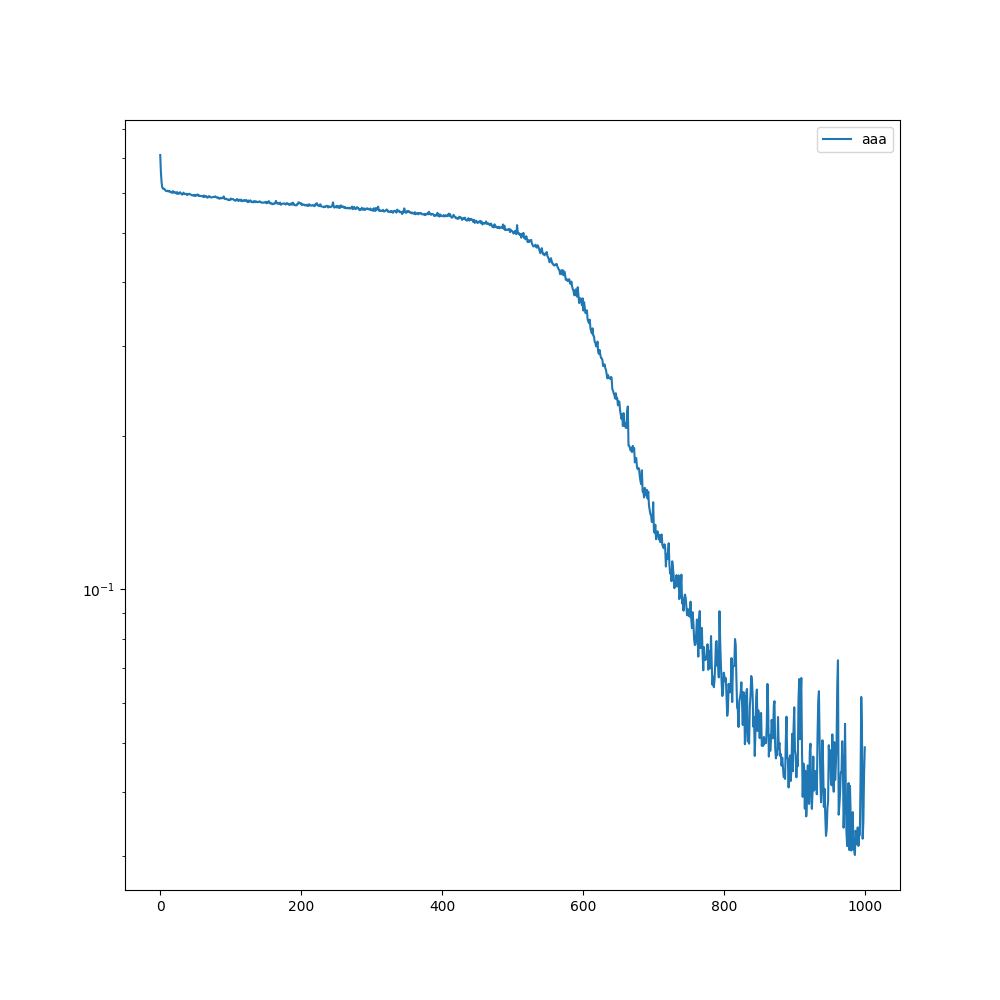

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(loss_history, label='aaa')
plt.yscale("log")
ax.legend()
plt.show()

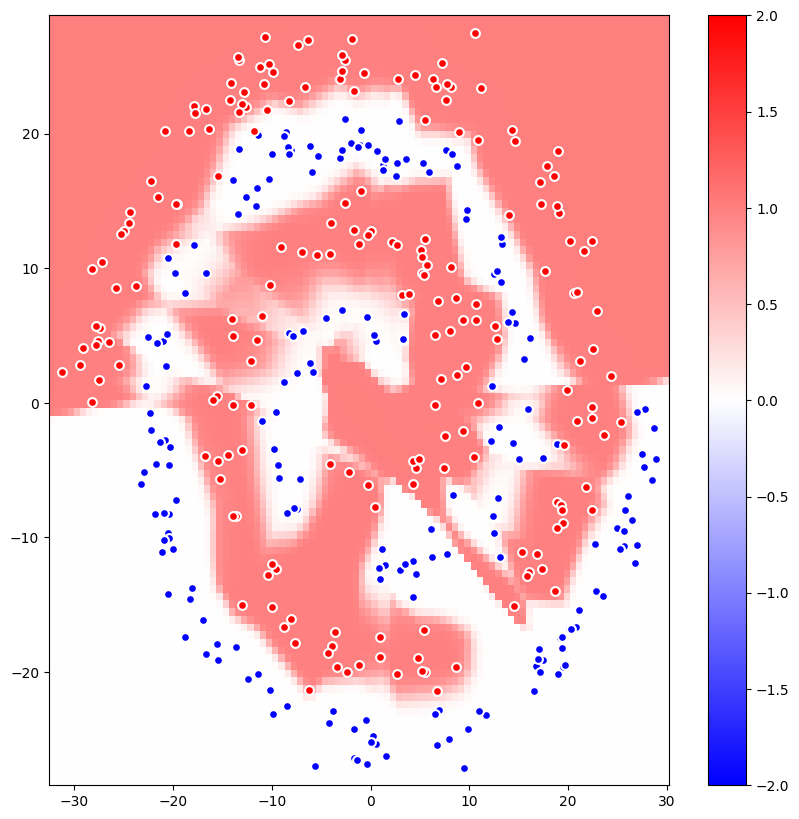

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
tmp = draw_mesh(model,ax,x_min, y_min, x_max, y_max, cmin=-2, cmax=2)
plt.colorbar(tmp, ax=ax)
draw_dots(X,y,ax)

plt.show()

# функции активации

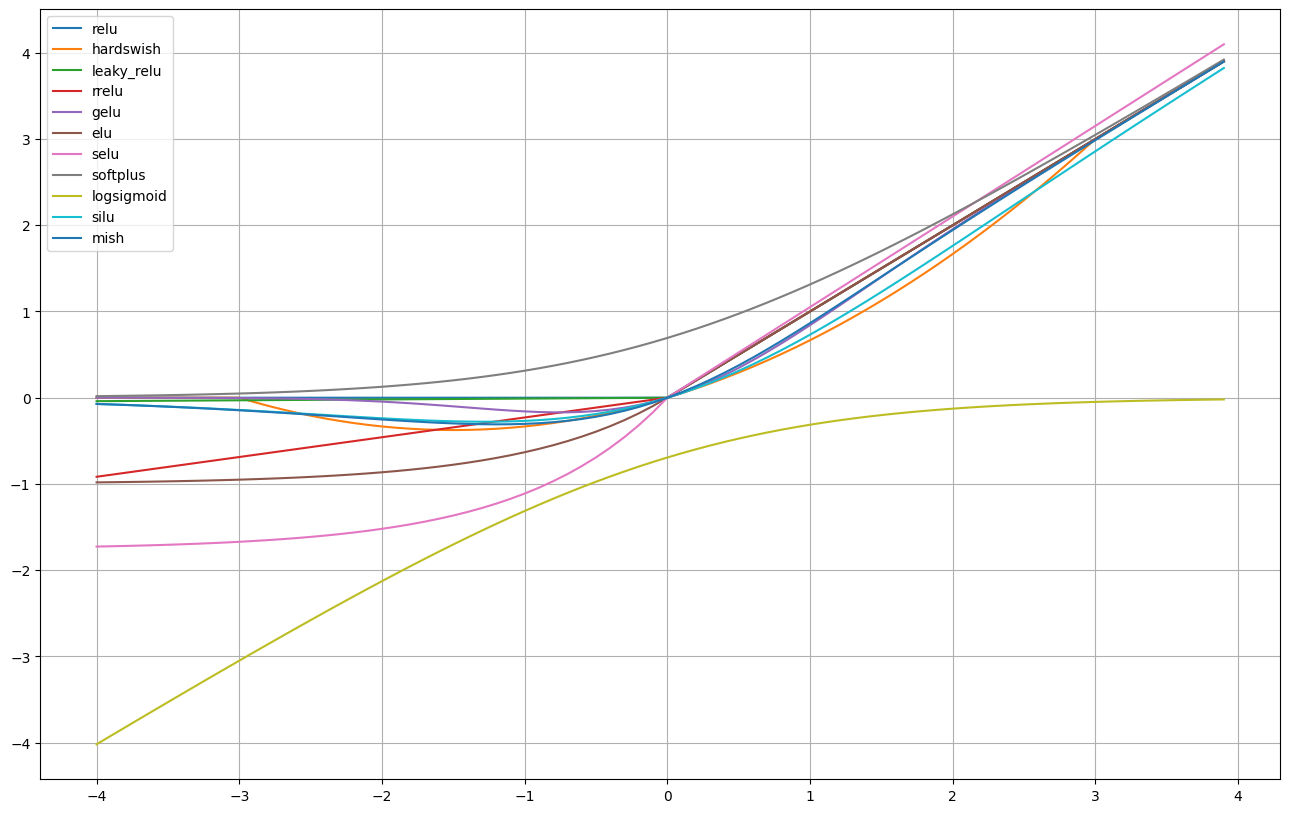

In [99]:
x = torch.arange(-4,4,0.1)

fig, ax = plt.subplots(figsize=(16, 10))

#ax.plot(x,Fun.threshold(x), label='threshold')
#ax.plot(x,Fun.prelu(x), label='prelu')
#ax.plot(x,Fun.glu(x), label='glu')
#ax.plot(x,Fun.softmin(x), label='softmin')
#ax.plot(x,Fun.softmax(x), label='softmax')
#ax.plot(x,Fun.log_softmax(x), label='log_softmax')



ax.plot(x,Fun.relu(x), label='relu')
#ax.plot(x,Fun.hardtanh(x), label='hardtanh')
#ax.plot(x,Fun.relu6(x), label='relu6')
ax.plot(x,Fun.hardswish(x), label='hardswish')
ax.plot(x,Fun.leaky_relu(x), label='leaky_relu')
ax.plot(x,Fun.rrelu(x), label='rrelu')
ax.plot(x,Fun.gelu(x), label='gelu')
ax.plot(x,Fun.elu(x), label='elu') # == #ax.plot(x,Fun.celu(x), label='celu')
ax.plot(x,Fun.selu(x), label='selu')
#ax.plot(x,Fun.logsigmoid(x), label='logsigmoid')
#ax.plot(x,Fun.hardshrink(x), label='hardshrink')
#ax.plot(x,Fun.tanhshrink(x), label='tanhshrink')
#ax.plot(x,Fun.softsign(x), label='softsign')
ax.plot(x,Fun.softplus(x), label='softplus')
#ax.plot(x,Fun.softshrink(x), label='softshrink')
#ax.plot(x,Fun.gumbel_softmax(x), label='gumbel_softmax')
#ax.plot(x,Fun.tanh(x), label='tanh')
#ax.plot(x,Fun.sigmoid(x), label='sigmoid')
#ax.plot(x,Fun.hardsigmoid(x), label='hardsigmoid')
ax.plot(x,Fun.logsigmoid(x), label='logsigmoid')
ax.plot(x,Fun.silu(x), label='silu')
ax.plot(x,Fun.mish(x), label='mish')
ax.legend()
ax.grid()
plt.show()

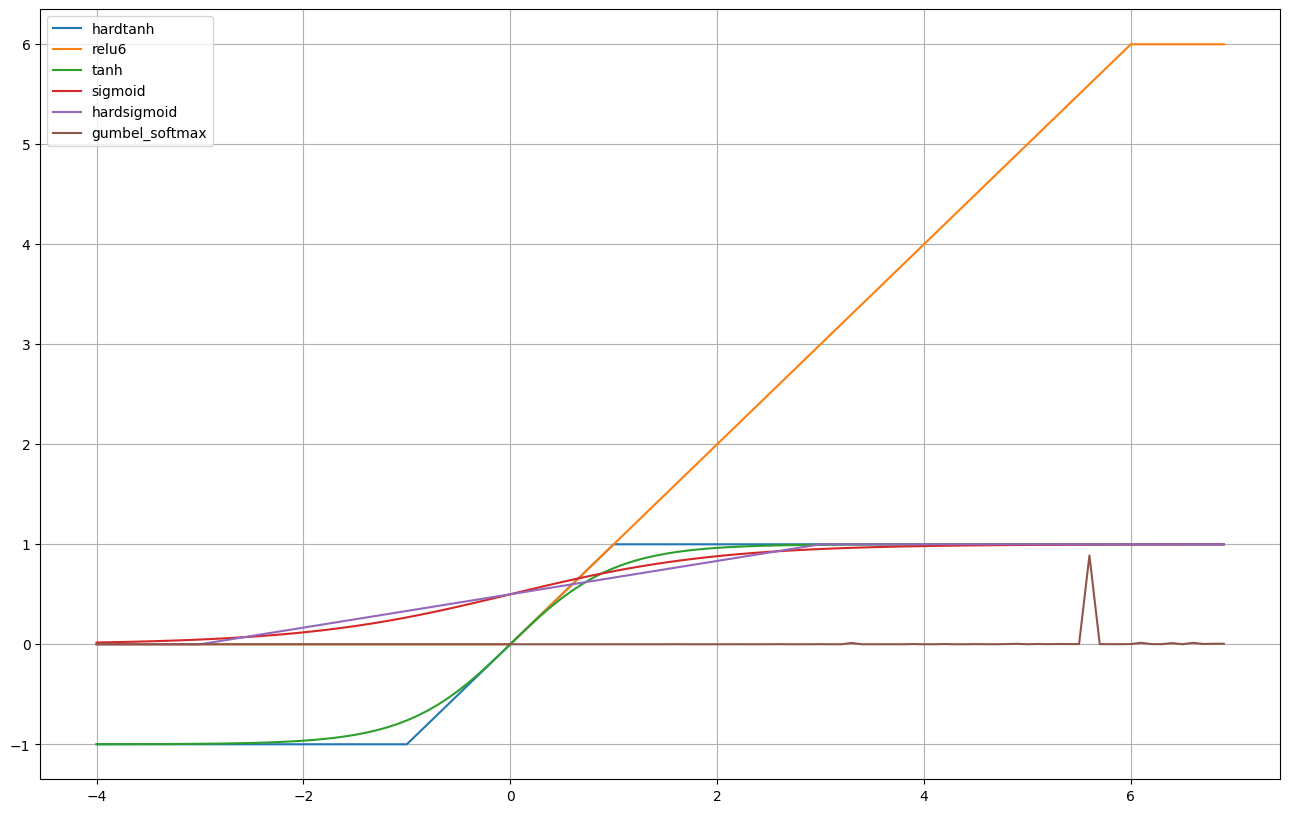

In [100]:
x = torch.arange(-4,7,0.1)

fig, ax = plt.subplots(figsize=(16, 10))

ax.plot(x,Fun.hardtanh(x), label='hardtanh')
ax.plot(x,Fun.relu6(x), label='relu6')
#ax.plot(x,Fun.logsigmoid(x), label='logsigmoid')
#ax.plot(x,Fun.hardshrink(x), label='hardshrink')
#ax.plot(x,Fun.tanhshrink(x), label='tanhshrink')
#ax.plot(x,Fun.softshrink(x), label='softshrink')
#ax.plot(x,Fun.gumbel_softmax(x), label='gumbel_softmax')
ax.plot(x,Fun.tanh(x), label='tanh')
ax.plot(x,Fun.sigmoid(x), label='sigmoid')
ax.plot(x,Fun.hardsigmoid(x), label='hardsigmoid')
ax.plot(x,Fun.gumbel_softmax(x), label='gumbel_softmax')
ax.legend()
ax.grid()
plt.show()

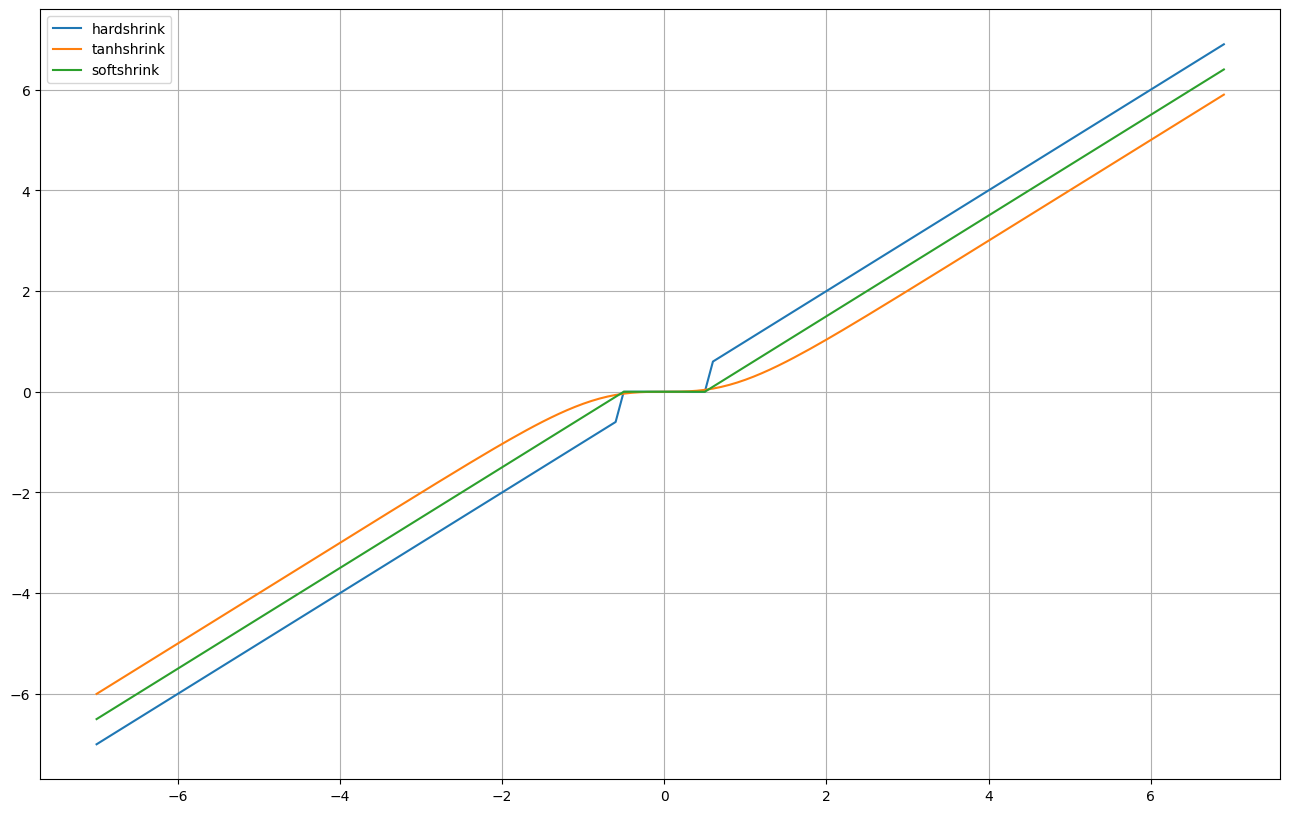

In [101]:
x = torch.arange(-7,7,0.1)

fig, ax = plt.subplots(figsize=(16, 10))

#ax.plot(x,Fun.logsigmoid(x), label='logsigmoid')
ax.plot(x,Fun.hardshrink(x), label='hardshrink')
ax.plot(x,Fun.tanhshrink(x), label='tanhshrink')
ax.plot(x,Fun.softshrink(x), label='softshrink')
#ax.plot(x,Fun.gumbel_softmax(x), label='gumbel_softmax')
ax.legend()
ax.grid()
plt.show()

# backward grad

In [102]:
x = torch.tensor([1.],requires_grad = True)
y = torch.tensor([2.],requires_grad = True)
z = torch.tensor([3.],requires_grad = True)

f = (x+y)*(y-z)
f

tensor([-3.], grad_fn=<MulBackward0>)

In [103]:
f.backward()
x.grad, y.grad, z.grad

(tensor([-1.]), tensor([2.]), tensor([-3.]))

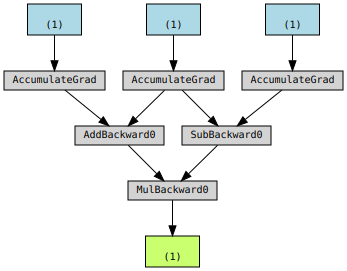

In [104]:
from torchviz import make_dot
make_dot(f)

# Пример задачи регрессии 3 параметра

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch

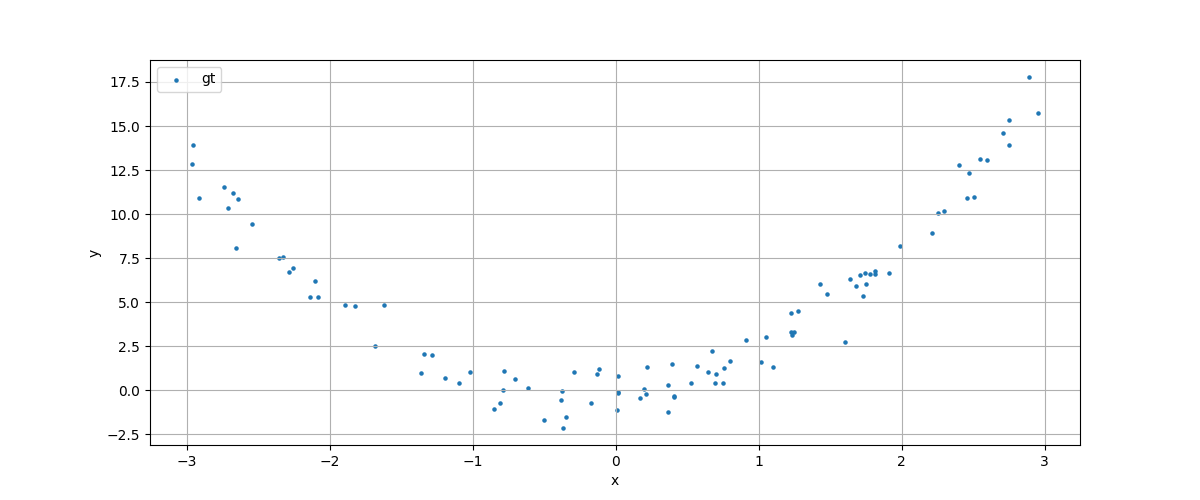

In [96]:
np.random.seed(1234)
_a = np.random.uniform(1, 5)
_b = np.random.uniform(-3, 3)
_c = np.random.uniform(-3, 3)

num_samples = 100

xs = np.random.uniform(-3, 3, size=num_samples)
ys_clean = _a * xs ** 2 + _b * xs + _c
ys_noise = np.random.normal(0, 1, size=len(ys_clean))
ys = ys_clean + ys_noise

plt.figure(figsize=(12, 5))
plt.scatter(xs, ys, label="gt", s=5)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

In [97]:
def model(x, a, b, c):
    return a * x ** 2 + b * x + c

In [98]:
device = torch.device("cuda")
#device = torch.device("cpu")

In [99]:
# YOUR CODE HERE
xs_device = torch.tensor(xs, device=device, requires_grad=False)
ys_device = torch.tensor(ys, device=device, requires_grad=False)
# END OF YOUR CODE

In [100]:
# YOUR CODE HERE
a = torch.randn(1, device=device, requires_grad=True)
b = torch.randn(1, device=device, requires_grad=True)
c = torch.randn(1, device=device, requires_grad=True)
# END OF YOUR CODE

In [103]:
num_epochs = 300
lr = 1e-4
indices = np.arange(len(xs))

loss_list, ys_pred_per_epoch = [], []


for epoch in trange(num_epochs):
    np.random.shuffle(indices)

    mean_loss = 0.
    for i in indices:
        # YOUR CODE HERE
        x      = xs_device[i]
        y_true = ys_device[i]
        y_pred = model(x,a,b,c)
        loss = (y_true - y_pred)**2
        loss.backward()
        # END OF YOUR CODE
        
        with torch.no_grad():
            #a.data -= lr * a.grad.data
            #b.data -= lr * b.grad.data
            #c.data -= lr * c.grad.data
            a -= lr * a.grad
            b -= lr * b.grad
            c -= lr * c.grad
            a.grad.zero_()
            b.grad.zero_()
            c.grad.zero_()
            
        mean_loss += loss.item()
		
        
    loss_list.append(mean_loss/len(xs))


  0%|          | 0/300 [00:00<?, ?it/s]

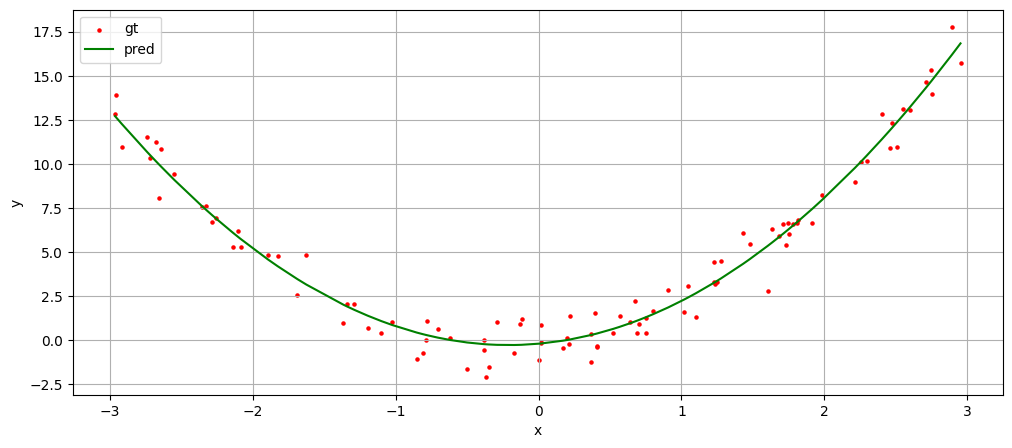

In [20]:
plt.figure(figsize=(12, 5))
plt.scatter(xs, ys, label="gt", s=5, c="r")

xs_sorted = np.sort(xs)
with torch.no_grad():
	ys_pred = model(xs_sorted, a.item(), b.item(), c.item())

plt.plot(xs_sorted, ys_pred, label="pred", c="g")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

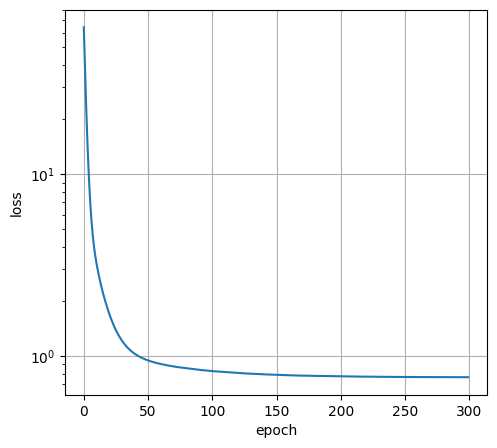

In [21]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True)
plt.yscale("log")

plt.show()

# примеры технологий

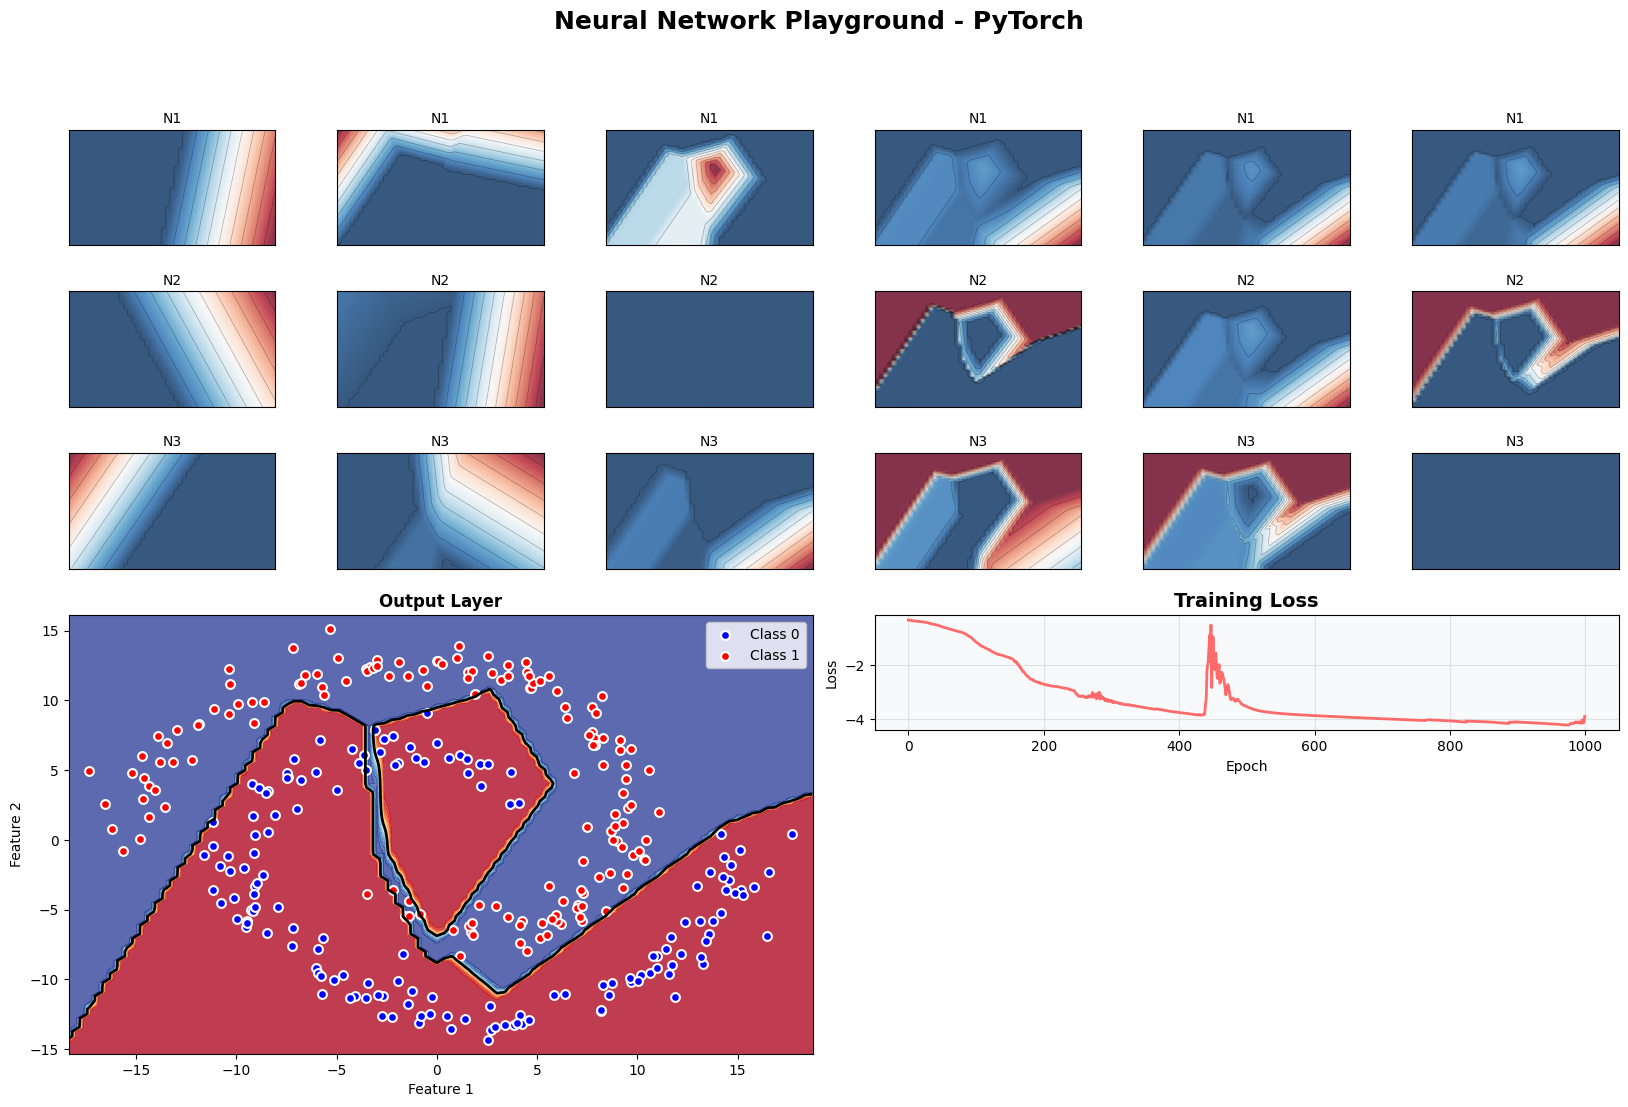

In [4]:
"""
Neural Network Playground - PyTorch Implementation
Интерактивная визуализация обучения нейронной сети с визуализацией активаций нейронов
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import display, clear_output
import ipywidgets as widgets
from sklearn.datasets import make_classification, make_circles, make_moons

# Установка случайного seed для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

class NeuralNetwork(nn.Module):
	"""Простая нейронная сеть с настраиваемой архитектурой"""
	def __init__(self, input_size=2, hidden_layers=[4, 4], activation='tanh'):
		super(NeuralNetwork, self).__init__()
		
		self.layers = nn.ModuleList()
		self.activations = []
		self.activation_type = activation
		
		prev_size = input_size
		
		# Скрытые слои
		for hidden_size in hidden_layers:
			self.layers.append(nn.Linear(prev_size, hidden_size))
			if activation == 'tanh':
				self.activations.append(nn.Tanh())
			elif activation == 'relu':
				self.activations.append(nn.ReLU())
			elif activation == 'sigmoid':
				self.activations.append(nn.Sigmoid())
			prev_size = hidden_size
		
		# Выходной слой
		self.layers.append(nn.Linear(prev_size, 1))
		self.output_activation = nn.Sigmoid()
		
		# Для хранения активаций
		self.layer_outputs = []
	
	def forward(self, x):
		self.layer_outputs = []
		
		for i, (layer, activation) in enumerate(zip(self.layers[:-1], self.activations)):
			x = layer(x)
			x = activation(x)
			self.layer_outputs.append(x.detach().clone())
		
		# Выходной слой
		x = self.layers[-1](x)
		x = self.output_activation(x)
		self.layer_outputs.append(x.detach().clone())
		
		return x

def generate_dataset(dataset_type='circle', n_samples=300, noise=1):
	"""Генерация различных типов датасетов"""
	if dataset_type == 'circle':
		X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5)
	elif dataset_type == 'xor':
		X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
								   n_informative=2, n_clusters_per_class=1,
								   flip_y=0.1, class_sep=0.5)
	elif dataset_type == 'moons':
		X, y = make_moons(n_samples=n_samples, noise=noise)
	elif dataset_type == 'spiral':
		n = n_samples // 2
		theta = np.sqrt(np.random.rand(n)) * 2 * np.pi
		r_a = 2 * theta + np.pi
		data_a = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
		x_a = data_a + np.random.randn(n, 2) * noise
		
		theta = np.sqrt(np.random.rand(n)) * 2 * np.pi
		r_b = -2 * theta - np.pi
		data_b = np.array([np.cos(theta) * r_b, np.sin(theta) * r_b]).T
		x_b = data_b + np.random.randn(n, 2) * noise
		
		X = np.vstack([x_a, x_b])
		y = np.hstack([np.zeros(n), np.ones(n)])
	else:  # linear
		X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
								   n_informative=2, n_clusters_per_class=1)
	
	return torch.FloatTensor(X), torch.FloatTensor(y).reshape(-1, 1)

def plot_neuron_activation(model, X, neuron_idx, layer_idx, ax, resolution=50):
	"""Визуализация активации конкретного нейрона"""
	x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
	y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
	
	xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
						 np.linspace(y_min, y_max, resolution))
	
	grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
	
	with torch.no_grad():
		_ = model(grid)
		activations = model.layer_outputs[layer_idx]
		Z = activations[:, neuron_idx].numpy().reshape(xx.shape)
	
	# Отображение активации нейрона
	im = ax.imshow(Z, extent=[x_min, x_max, y_min, y_max], 
				   origin='lower', cmap='RdBu_r', alpha=0.8, aspect='auto')
	ax.contour(xx, yy, Z, levels=10, colors='black', linewidths=0.5, alpha=0.3)
	
	ax.set_xlim(x_min, x_max)
	ax.set_ylim(y_min, y_max)
	ax.set_xticks([])
	ax.set_yticks([])
	ax.set_title(f'N{neuron_idx+1}', fontsize=10, pad=5)
	
	return im

def plot_decision_boundary(model, X, y, ax, resolution=100):
	"""Визуализация границы решения"""
	x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
	y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
	
	xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
						 np.linspace(y_min, y_max, resolution))
	
	grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
	
	with torch.no_grad():
		Z = model(grid).numpy().reshape(xx.shape)
	
	ax.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.8)
	ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
	
	# Отображение точек данных
	X_np, y_np = X.numpy(), y.numpy().flatten()
	ax.scatter(X_np[y_np == 0, 0], X_np[y_np == 0, 1], 
			   c='blue', s=40, edgecolors='white', linewidths=1.5, label='Class 0')
	ax.scatter(X_np[y_np == 1, 0], X_np[y_np == 1, 1], 
			   c='red', s=40, edgecolors='white', linewidths=1.5, label='Class 1')
	
	ax.set_xlim(x_min, x_max)
	ax.set_ylim(y_min, y_max)
	ax.set_xlabel('Feature 1')
	ax.set_ylabel('Feature 2')
	ax.legend(loc='upper right')
	ax.set_title('Output Layer', fontweight='bold')

def visualize_network(model, X, y, loss_history, accuracy_history):
	"""Визуализация всей сети с активациями нейронов"""
	
	# Подсчет количества нейронов в каждом слое
	hidden_layers = [layer.out_features for layer in model.layers[:-1]]
	num_layers = len(hidden_layers)
	max_neurons = max(hidden_layers) if hidden_layers else 0
	
	# Создание сетки для графиков
	fig = plt.figure(figsize=(20, 12))
	gs = GridSpec(max_neurons + 3, max(num_layers,5), figure=fig, hspace=0.4, wspace=0.3)
	
	# Получаем активации для всех нейронов
	with torch.no_grad():
		_ = model(X)
	
	# Визуализация скрытых слоев
	for layer_idx, num_neurons in enumerate(hidden_layers):
		for neuron_idx in range(num_neurons):
			ax = fig.add_subplot(gs[neuron_idx, layer_idx])
			plot_neuron_activation(model, X, neuron_idx, layer_idx, ax)
		
		# Заголовок слоя
		ax_title = fig.add_subplot(gs[max_neurons, layer_idx])
		ax_title.text(0.5, 0.5, f'Hidden Layer {layer_idx + 1}\n({num_neurons} neurons)', 
					  ha='center', va='center', fontsize=12, fontweight='bold')
		ax_title.axis('off')
	
	# Визуализация выходного слоя
	ax_output = fig.add_subplot(gs[max_neurons:, 0:3])
	plot_decision_boundary(model, X, y, ax_output)
	
	# График потерь
	ax_loss = fig.add_subplot(gs[max_neurons, 3:])
	ax_loss.plot(np.log(np.array(loss_history)), color='#FF6B6B', linewidth=2)
	ax_loss.set_title('Training Loss', fontweight='bold', fontsize=14)
	ax_loss.set_xlabel('Epoch')
	ax_loss.set_ylabel('Loss')
	ax_loss.grid(True, alpha=0.3)
	ax_loss.set_facecolor('#F8F9FA')
	
	# График точности
#	ax_acc = fig.add_subplot(gs[max_neurons+1:, 3:])
#	ax_acc.plot(accuracy_history, color='#51CF66', linewidth=2)
#	ax_acc.set_title('Training Accuracy', fontweight='bold', fontsize=14)
#	ax_acc.set_xlabel('Epoch')
#	ax_acc.set_ylabel('Accuracy')
#	ax_acc.grid(True, alpha=0.3)
#	ax_acc.set_facecolor('#F8F9FA')
	
	# Информация о модели
#	ax_info = fig.add_subplot(gs[max_neurons:, num_layers+1:])
#	info_text = f"Architecture: {[2] + hidden_layers + [1]}\n"
#	info_text += f"Activation: {model.activation_type}\n"
#	info_text += f"Final Loss: {loss_history[-1]:.4f}\n"
#	info_text += f"Final Accuracy: {accuracy_history[-1]:.4f}\n"
#	info_text += f"Total Parameters: {sum(p.numel() for p in model.parameters())}"
#	ax_info.text(0.1, 0.5, info_text, ha='left', va='center', 
#				 fontsize=11, family='monospace',
#				 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
#	ax_info.axis('off')
	
	plt.suptitle('Neural Network Playground - PyTorch', 
				 fontsize=18, fontweight='bold', y=0.98)
	
	return fig

def train_network(dataset_type='circle', hidden_layers=[4, 4], 
				 activation='tanh', learning_rate=0.01, 
				 epochs=1000, plot_every=50):
	global model
	global loss_history
	global accuracy_history

	"""Обучение нейронной сети с визуализацией"""
	
	# Генерация данных
	X, y = generate_dataset(dataset_type)
	
	# Создание модели
	model = NeuralNetwork(input_size=2, hidden_layers=hidden_layers, 
						 activation=activation)
	
	# Функция потерь и оптимизатор
	criterion = nn.BCELoss()
	optimizer = optim.Adam(model.parameters(), lr=learning_rate)
	
	# История обучения
	loss_history = []
	accuracy_history = []
	
	print(f"🚀 Обучение начато...")
	print(f"📊 Dataset: {dataset_type}")
	print(f"🧠 Architecture: {[2] + hidden_layers + [1]}")
	print(f"⚡ Activation: {activation}")
	print(f"📈 Learning Rate: {learning_rate}")
	print("-" * 70)
	
	for epoch in range(epochs):
		# Прямой проход
		outputs = model(X)
		loss = criterion(outputs, y)
		
		# Обратное распространение
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		# Расчет точности
		predicted = (outputs > 0.5).float()
		accuracy = (predicted == y).float().mean()
		
		loss_history.append(loss.item())
		accuracy_history.append(accuracy.item())
		
		# Визуализация
		if (epoch + 1) % plot_every == 0 or epoch == 0:
			print(f"Epoch {epoch+1:4d}/{epochs} - Loss: {loss.item():.4f}, "
				  f"Accuracy: {accuracy.item():.4f}")
			
			clear_output(wait=True)
			
			fig = visualize_network(model, X, y, loss_history, accuracy_history)
			plt.show()
			
			print(f"\n🎯 Epoch {epoch+1}/{epochs}")
			print(f"📉 Loss: {loss.item():.4f}")
			print(f"🎯 Accuracy: {accuracy.item():.4f}")
			print("-" * 70)
	
	print("\n✅ Обучение завершено!")
	print(f"📉 Финальная Loss: {loss_history[-1]:.4f}")
	print(f"🎯 Финальная Accuracy: {accuracy_history[-1]:.4f}")
	
	# Финальная визуализация
	clear_output(wait=True)
	fig = visualize_network(model, X, y, loss_history, accuracy_history)
	plt.show()
	
# Интерактивные виджеты для настройки параметров
def create_interactive_playground():
	"""Создание интерактивного интерфейса"""
	
	dataset_widget = widgets.Dropdown(
		options=['circle', 'xor', 'moons', 'spiral', 'linear'],
		value='circle',
		description='Dataset:',
		style={'description_width': 'initial'}
	)
	
	activation_widget = widgets.Dropdown(
		options=['tanh', 'relu', 'sigmoid'],
		value='tanh',
		description='Activation:',
		style={'description_width': 'initial'}
	)
	
	lr_widget = widgets.FloatLogSlider(
		value=0.01,
		base=10,
		min=-4,
		max=-1,
		step=0.1,
		description='Learning Rate:',
		style={'description_width': 'initial'}
	)
	
	epochs_widget = widgets.IntSlider(
		value=500,
		min=100,
		max=2000,
		step=100,
		description='Epochs:',
		style={'description_width': 'initial'}
	)
	
	hidden1_widget = widgets.IntSlider(
		value=4,
		min=2,
		max=8,
		step=1,
		description='Hidden Layer 1:',
		style={'description_width': 'initial'}
	)
	
	hidden2_widget = widgets.IntSlider(
		value=4,
		min=2,
		max=8,
		step=1,
		description='Hidden Layer 2:',
		style={'description_width': 'initial'}
	)
	
	button = widgets.Button(
		description="🚀 Train Network",
		button_style='success',
		layout=widgets.Layout(width='200px', height='40px')
	)
	output = widgets.Output()
	
	def on_button_click(b):
		with output:
			clear_output()
			hidden_layers = [hidden1_widget.value, hidden2_widget.value]
			train_network(
				dataset_type=dataset_widget.value,
				hidden_layers=hidden_layers,
				activation=activation_widget.value,
				learning_rate=lr_widget.value,
				epochs=epochs_widget.value,
				plot_every=50
			)
	
	button.on_click(on_button_click)
	
	ui = widgets.VBox([
		widgets.HTML('<h2>🧠 Neural Network Playground - PyTorch</h2>'),
		widgets.HTML('<hr>'),
		widgets.HBox([dataset_widget, activation_widget]),
		widgets.HBox([lr_widget, epochs_widget]),
		widgets.HBox([hidden1_widget, hidden2_widget]),
		button,
		output
	])
	
	display(ui)

# Пример использования
print("=" * 70)
print("🧠 Neural Network Playground - PyTorch")
print("=" * 70)
print("\n📚 Доступные функции:")
print("1. train_network() - обучение с параметрами по умолчанию")
print("2. create_interactive_playground() - интерактивный интерфейс")
print("\n💡 Пример использования:")
print("model, loss, acc = train_network(")
print("    dataset_type='circle',")
print("    hidden_layers=[6, 4],")
print("    activation='tanh',")
print("    learning_rate=0.01,")
print("    epochs=500")
print(")")
print("\n" + "=" * 70)

# Запуск обучения с параметрами по умолчанию
train_network(dataset_type='spiral', hidden_layers=[3, 3, 3, 3, 3, 3], 
			 activation='relu', learning_rate=0.01, epochs=1000, plot_every=50)

In [2]:
from ipycanvas import Canvas
import ipywidgets as widgets
import numpy as np

# --- Canvas ---
w, h = 600, 300
canvas = Canvas(width=w, height=h)

# начальная частота
freq = 1.0

# --- функция рисования ---
def draw_sine(f):
	canvas.clear()

	# параметры
	A = h * 0.4
	y0 = h * 0.5

	# генерируем кривую
	xs = np.linspace(0, w, 800)
	ys = y0 + A * np.sin(2 * np.pi * f * xs / w)

	# рисуем линию
	canvas.begin_path()
	canvas.move_to(xs[0], ys[0])
	for x, y in zip(xs[1:], ys[1:]):
		canvas.line_to(x, y)
	canvas.stroke()

# --- слайдер ---
slider = widgets.FloatSlider(
	value=freq,
	min=0.1,
	max=10.0,
	step=0.1,
	description='freq',
	continuous_update=True
)

# callback
def on_freq_change(change):
	if change['name'] == 'value':
		draw_sine(change['new'])

slider.observe(on_freq_change)

# первый рендер
draw_sine(freq)

widgets.VBox([canvas, slider])


In [2]:
import numpy as np
import fastplotlib as fpl

# === данные ===
heat = np.random.rand(50, 50)

x = np.linspace(0, 2*np.pi, 500)
y1 = np.sin(x)
y2 = np.sin(2 * x)
y3 = np.sin(3 * x)

big_heat = np.random.rand(200, 200)
pts = np.random.rand(100, 2) * np.array([200, 200])

# === создаём фигуру ===
fig = fpl.Figure()

# === верхняя сетка 5×5 ===
top_grid = fig.add_grid(5, 5)

for i in range(5):
	for j in range(5):
		p = fig.add_plot()
		p.add_image(heat)
		top_grid[i, j] = p

# === нижняя строка: слева графики, справа heatmap+points ===
bottom_row = fig.add_row(1)[0]
left_col, right_col = bottom_row.add_columns(2)

# --- синусоиды ---
plot_sin = fig.add_plot()
plot_sin.add_line(x, y1)
plot_sin.add_line(x, y2)
plot_sin.add_line(x, y3)
left_col[0] = plot_sin

# --- большая карта + точки ---
plot_big = fig.add_plot()
plot_big.add_image(big_heat)
plot_big.add_scatter(pts)
right_col[0] = plot_big

# === показать ===
fig.show()


Unable to find extension: VK_EXT_physical_device_drm
No config found!
EGL says it can present to the window but not natively
Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),NVIDIA GeForce RTX 3050,DiscreteGPU,Vulkan,570.195.03
❗ limited,"llvmpipe (LLVM 20.1.2, 256 bits)",CPU,Vulkan,Mesa 25.0.7-0ubuntu0.24.04.2 (LLVM 20.1.2)
❌,NVIDIA GeForce RTX 3050/PCIe/SSE2,Unknown,OpenGL,3.3.0 NVIDIA 570.195.03


Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048


RFBOutputContext()

Max vertex attribute stride unknown. Assuming it is 2048


AttributeError: 'Figure' object has no attribute 'add_grid'

In [9]:
import anywidget
import traitlets as t

class EmailWidget(anywidget.AnyWidget):
	_email = t.Unicode("qwe").tag(sync=True)

	_esm = """
		export function render({ model, el }) {
			el.innerHTML = `
				<div style="font-family: sans-serif;">
					<label>Email: <input id="email" type="email" /></label>
				</div>
			`;

			const input = el.querySelector("#email");

			// init from python
			input.value = model.get("_email");

			// python → js
			model.on("change:_email", () => {
				input.value = model.get("_email");
			});

			// js → python
			input.addEventListener("input", () => {
				model.set("_email", input.value);
				model.save_changes();
			});
		}
	"""


In [11]:
email = EmailWidget()
email

In [12]:
email._email

'qwesss'

In [112]:
import json
lp = 0
for i in range(3000):
	s = json.dumps({'x':chr(i)}, ensure_ascii=False)[7:-2]
	l = len(s)
	if l==1 and lp!=1:
		print('\t',i,'-',end='')
	if l!=1 and lp==1:
		print(i)
	if l!=1:
		print(i,s)
	lp = l

0 \u0000
1 \u0001
2 \u0002
3 \u0003
4 \u0004
5 \u0005
6 \u0006
7 \u0007
8 \b
9 \t
10 \n
11 \u000b
12 \f
13 \r
14 \u000e
15 \u000f
16 \u0010
17 \u0011
18 \u0012
19 \u0013
20 \u0014
21 \u0015
22 \u0016
23 \u0017
24 \u0018
25 \u0019
26 \u001a
27 \u001b
28 \u001c
29 \u001d
30 \u001e
31 \u001f
	 32 -34
34 \"
	 35 -92
92 \\
	 93 -

In [166]:
from plotly.colors import get_colorscale
import colorsys
import re
for x,c in get_colorscale('RdBu_r'):
	o = re.match(r'rgb\((\d*),(\d*),(\d*)\)',c)
	hls = colorsys.rgb_to_hls(int(o.group(1))/255,int(o.group(2))/255,int(o.group(3))/255)
	hsv = colorsys.rgb_to_hsv(int(o.group(1))/255,int(o.group(2))/255,int(o.group(3))/255)
	print(f'{x:3.1f} {c:16}   {hls[0]:.2f} {hls[2]:5.3} {hls[1]:5.3}    {hsv[0]:5.2} {hsv[1]:5.3} {hsv[2]:5.3}')

0.0 rgb(5,48,97)       0.59 0.902   0.2     0.59 0.948  0.38
0.1 rgb(33,102,172)    0.58 0.678 0.402     0.58 0.808 0.675
0.2 rgb(67,147,195)    0.56 0.516 0.514     0.56 0.656 0.765
0.3 rgb(146,197,222)   0.55 0.535 0.722     0.55 0.342 0.871
0.4 rgb(209,229,240)   0.56 0.508  0.88     0.56 0.129 0.941
0.5 rgb(247,247,247)   0.00   0.0 0.969      0.0   0.0 0.969
0.6 rgb(253,219,199)   0.06 0.931 0.886    0.062 0.213 0.992
0.7 rgb(244,165,130)   0.05 0.838 0.733    0.051 0.467 0.957
0.8 rgb(214,96,77)     0.02 0.626 0.571    0.023  0.64 0.839
0.9 rgb(178,24,43)     0.98 0.762 0.396     0.98 0.865 0.698
1.0 rgb(103,0,31)      0.95   1.0 0.202     0.95   1.0 0.404


In [69]:
print(f'{247.:.3}')

2.47e+02


In [53]:
re.match('a.*','asdf')

<re.Match object; span=(0, 4), match='asdf'>

In [5]:
rb,gb,bb = 5,48,97
rw,gw,bw = 247,247,247
rr,gr,br = 103,0,31

rd,gd,bd = (rw-rb)/5, (gw-gb)/5, (bw-bb)/5
for i in range(5):
	print(i, int(rb+rd*i), int(gb+gd*i), int(bb+bd*i))

rd,gd,bd = (rr-rw)/5, (gr-gw)/5, (br-bw)/5
for i in range(5):
	print(i, int(rw+rd*i), int(gw+gd*i), int(bw+bd*i))

0 5 48 97
1 53 87 127
2 101 127 157
3 150 167 187
4 198 207 217
0 247 247 247
1 218 197 203
2 189 148 160
3 160 98 117
4 131 49 74


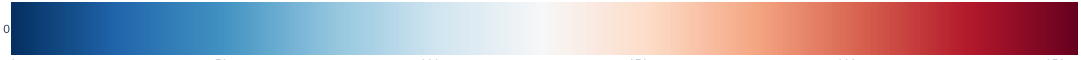

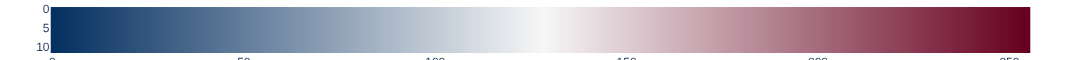

In [43]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
fig = go.Figure()
fig.add_trace(go.Heatmap(
	z=np.linspace(-10,10,256).reshape(1,256),
	zmin=-10, zmid=0, zmax=10,
	colorscale = 'RdBu_r',showscale=False
		#get_colorscale('RdBu')[::-1],
		#[	[0.0, 'blue'],	[0.5, 'white'],	[1.0, 'red'],],
))
fig.update_layout(margin=dict(l=3,r=3,t=3,b=3), width=1000, height=60)
fig.show()

fig = go.Figure()
r = np.hstack([np.linspace(5,247,129)[:-1],np.linspace(247,103,128)])
g = np.hstack([np.linspace(48,247,129)[:-1],np.linspace(247,0,128)])
b = np.hstack([np.linspace(97,247,129)[:-1],np.linspace(247,31,128)])
c = np.vstack([r,g,b]).T.astype('u8').reshape(1,256,3)
c = np.vstack([c,c,c,c,c,c,c,c,c,c,c,c])
fig.add_trace(go.Image(	z=c))
fig.update_layout(margin=dict(l=3,r=3,t=3,b=3), width=1000, height=60)
fig.show()





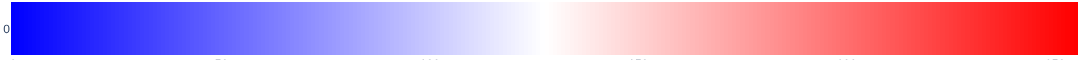

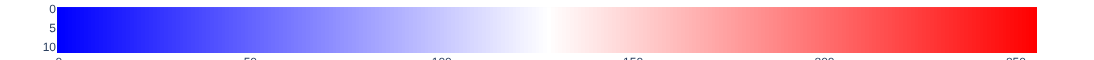

In [44]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
fig = go.Figure()
fig.add_trace(go.Heatmap(
	z=np.linspace(-10,10,256).reshape(1,256),
	zmin=-10, zmid=0, zmax=10,
	colorscale = [[0.0, 'rgb(0,0,255)'],
 [0.5, 'rgb(255,255,255)'],
 [1.0, 'rgb(255,0,0)']],showscale=False
		#get_colorscale('RdBu')[::-1],
		#[	[0.0, 'blue'],	[0.5, 'white'],	[1.0, 'red'],],
))
fig.update_layout(margin=dict(l=3,r=3,t=3,b=3), width=1000, height=60)
fig.show()

fig = go.Figure()
r = np.hstack([np.linspace(0  ,255,129)[:-1],np.linspace(255,255,128)])
g = np.hstack([np.linspace(0  ,255,129)[:-1],np.linspace(255,0,128)])
b = np.hstack([np.linspace(255,255,129)[:-1],np.linspace(255,0,128)])
c = np.vstack([r,g,b]).T.astype('u8').reshape(1,256,3)
c = np.vstack([c,c,c,c,c,c,c,c,c,c,c,c])
fig.add_trace(go.Image(	z=c))
fig.update_layout(margin=dict(l=3,r=3,t=3,b=3), width=1000, height=60)
fig.show()





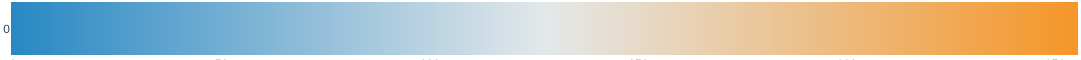

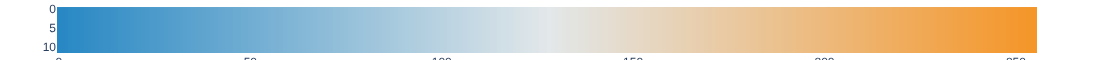

In [83]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
fig = go.Figure()
fig.add_trace(go.Heatmap(
	z=np.linspace(-10,10,256).reshape(1,256),
	zmin=-10, zmid=0, zmax=10,
	colorscale = [[0.0, 'rgb(40,136,196)'],
 [0.5, 'rgb(227,232,234)'],
 [1.0, 'rgb(245,150,40)']],showscale=False
		#get_colorscale('RdBu')[::-1],
		#[	[0.0, 'blue'],	[0.5, 'white'],	[1.0, 'red'],],
))
fig.update_layout(margin=dict(l=3,r=3,t=3,b=3), width=1000, height=60)
fig.show()

fig = go.Figure()
r = np.hstack([np.linspace(40 ,227,129)[:-1],np.linspace(227,245,128)])
g = np.hstack([np.linspace(136,232,129)[:-1],np.linspace(232,150,128)])
b = np.hstack([np.linspace(196,234,129)[:-1],np.linspace(234,40,128)])
c = np.vstack([r,g,b]).T.astype('u8').reshape(1,256,3)
c = np.vstack([c,c,c,c,c,c,c,c,c,c,c,c])
fig.add_trace(go.Image(	z=c))
fig.update_layout(margin=dict(l=3,r=3,t=3,b=3), width=1000, height=60)
fig.show()





(0.5887681159420289, 51.0, -0.92)

In [ ]:
colorsys.hls_to_rgb(5,48,97)